In [1]:
'''Potential Improvements
Do not use theoretical considerations?
Use bigger axis fonts
Use bar graphs instead of numbers to compare models
Use introduction providing context of why we are doing this in first place (i.e. collisions) (presentation)
Don't use too many significant digits for error presentation
Too much text? (presentation)

Use logspace plotting
Use better error metrics, since the predictions span multiple orders of magnitude. Larger masses dominate error.
    Scale target to total mass
Correct for non-physical predictions (negative masses)



'''

"Potential Improvements\nDo not use theoretical considerations?\nUse bigger axis fonts\nUse bar graphs instead of numbers to compare models\nUse introduction providing context of why we are doing this in first place (i.e. collisions) (presentation)\nDon't use too many significant digits for error presentation\nToo much text? (presentation)\n\nUse logspace plotting\nUse better error metrics, since the predictions span multiple orders of magnitude. Larger masses dominate error.\n    Scale target to total mass\nCorrect for non-physical predictions (negative masses)\n\n\n\n"

# Module Calls

In [93]:
############### PYTHON 3



#Module Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xgboost as xgb
from scipy.stats import randint as sp_randint
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, validation_curve, learning_curve
from sklearn import metrics

%matplotlib inline

print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(xgb.__version__)

1.13.3
0.20.3
0.8.0
0.7


# Function Definitions

In [86]:
#Plot feature importance (bar graph)

def feat_imp_plot(regressor, X, feature):
    feat_imp = np.sort(regressor.feature_importances_)
    fig, ax = plt.subplots(figsize=(15,8))
    xs = np.arange(0,len(X.columns))
    plt.bar(xs,feat_imp)
    plt.title(feature+" "+(str(regressor)).split("(",1)[0]+" Feature Importance")
    plt.ylabel((str(regressor)).split("(",1)[0]+" Feature Importance Score")
    plt.xticks(xs,list(X))
    #plt.savefig((feature+" Feature Importance Graph with "+(str(regressor)).split("(",1)[0])+".png", bbox_inches='tight', format='png')

In [95]:
#Learning curves to get an idea of optimal train-test-split

def learning_curve_plot(regressor, X, y, feature):
    fig, ax = plt.subplots(figsize=(15,8))
    train_sizes, train_scores, test_scores = learning_curve(
        regressor, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.title("Learning Curve with "+(str(regressor)).split("(",1)[0]+" "+feature)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    #plt.savefig("Learning Curve with "+(str(regressor)).split("(",1)[0]+" "+feature+".png", bbox_inches='tight', format='png')

In [124]:
#Validation curves to get an idea of optimal hyperparameters

def valid_curve_plot(X, y, regressor, param_name, param_range, score_metric):
    train_scores, test_scores = validation_curve(regressor, X, y, param_name=param_name, 
                                                 param_range=param_range, cv=5, scoring=score_metric, n_jobs=-1)
    
    fig, ax = plt.subplots(figsize=(8,8))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

    plt.title(score_metric+" Validation Curve with "+(str(regressor)).split("(",1)[0])
    plt.xlabel(param_name)
    plt.ylabel(score_metric+" Score")
    plt.legend(loc="best")
    plt.grid()
    #plt.savefig(score_metric+" "+param_name+" Validation Curve with "+(str(regressor)).split("(",1)[0]+".png", bbox_inches='tight', format='png')

In [281]:
#Plot and compare the regressors using simple histogram (function)

def plotfunct(regressor,scores,feature,testX_set,testy_set,score_metric,scaler):
    fig, ax = plt.subplots(figsize=(8,8))
    #Convert predictions and actuals back into Earth masses
    preds_0 = (regressor.predict(testX_set))*scaler.inverse_transform(testX_set)[:,4]#np.power(10,scaler.inverse_transform(testX_set)[:,3])
    actuals_0 = (testy_set.values.ravel())*scaler.inverse_transform(testX_set)[:,4]#np.power(10,scaler.inverse_transform(testX_set)[:,3])
    if score_metric == "R2":
        score_final = metrics.r2_score(actuals_0,preds_0)
        print((str(regressor)).split("(",1)[0]+": "+str(score_final))
    elif score_metric == "MAE":
        score_final = metrics.mean_absolute_error(actuals_0,preds_0)
        print((str(regressor)).split("(",1)[0]+": "+str(score_final))
    else:
        score_final = metrics.mean_squared_log_error(actuals_0,preds_0)
        print((str(regressor)).split("(",1)[0]+": "+str(score_final))
    n, bins, patches = plt.hist(actuals_0,color="red",ls="dotted",alpha = 0.5,lw=3)
    plt.hist(preds_0,color="green",ls="dashed",alpha = 0.5,lw=3,bins=bins)
    plt.title(score_metric+" Scores: "+str(score_final)+"      "+feature+"     Regression by "+(str(regressor)).split("(",1)[0])
    plt.xlabel("Remnant Mass (Earth Masses)")
    plt.ylabel("Frequency")
    red_patch, green_patch = mpatches.Patch(color="green", label="Predictions"), mpatches.Patch(color="red", label="Actual")
    plt.legend(handles=[red_patch,green_patch], loc="best")
    plt.grid()
    plt.savefig(("figures/"+feature+" "+score_metric+" Scores "+str(str(regressor)).split("(",1)[0])+" (Earth Masses).png", bbox_inches='tight', format='png')
    
    fig, ax = plt.subplots(figsize=(8,8))
    preds_1 = (regressor.predict(testX_set))
    actuals_1 = (testy_set.values.ravel())
    n, bins, patches = plt.hist(actuals_1,color="red",ls="dotted",alpha = 0.5,lw=3)
    plt.hist(preds_1,color="green",ls="dashed",alpha = 0.5,lw=3,bins=bins)
    plt.title(score_metric+" Scores: "+str(scores)+"      "+feature+"     Regression by "+(str(regressor)).split("(",1)[0])
    plt.xlabel("Remnant Mass/Total Mass")
    plt.ylabel("Frequency")
    red_patch, green_patch = mpatches.Patch(color="green", label="Predictions"), mpatches.Patch(color="red", label="Actual")
    plt.legend(handles=[red_patch,green_patch], loc="best")
    plt.grid()
    plt.savefig(("figures/"+feature+" "+score_metric+" Scores "+str(str(regressor)).split("(",1)[0])+" (Adjusted Remnant Mass).png", bbox_inches='tight', format='png')
    
    return(score_final)

In [6]:
#Create simple linear regression model
def linmodel(testsamples,iterations,X,y):
    scores = np.empty([iterations,1])
    scoresmeanlist = np.empty([iterations,1])
    coefflist = np.empty([iterations,len(X.columns)])
    coeffdict = dict()
    
    #Split data into test/train groups
    for j in range(iterations):
        i = np.random.choice(779,testsamples,replace=False)
        testX = X.iloc[i]
        testy = y.iloc[i]   

        trainX = X.drop(i,axis=0)
        trainy = y.drop(i,axis=0)
        
        lm = LinearRegression()
        lm.fit(trainX, trainy)

        #print(lm.intercept_)
        coeffs = lm.coef_
       
        
        scores = cross_val_score(lm, testX, testy, cv=5, scoring='r2')
        #print(scores)

        #Prints the (positive) average metric score
        scoresmean = np.mean(np.sqrt(np.abs(scores)))
        
        #Appends each 1) mean score 2) coefficients to lists
        scoresmeanlist[j] = scoresmean
        coefflist[j] = coeffs
    scoresfinal = np.mean(scoresmeanlist)
    coefffinal = np.mean(coefflist, axis=0)
    for i in range(len(X.columns)):
        coeffdict[list(X)[i]] = coefffinal[i]
    return(lm,testX,testy,testsamples,scoresfinal,coeffdict)

In [7]:
#Function to scale data using Standardscaler

def datascale(X):
    scaler = StandardScaler().fit(X.loc[:,:])
    X.loc[:,:] = scaler.transform(X.loc[:,:])
    print(X.tail())
    return(X, scaler)

In [128]:
###############  Use more advanced regressors

#Random Forest Function
#Randomized Grid Search Hyper-parameter Optimization
def RFregressorFunct(X, y, trainX, testX, trainy, testy, score_metric):
    param_dist = {"n_estimators": np.arange(50,500),
                  "max_depth": np.arange(3,25),
                  "max_features": np.arange(1, len(X.columns))}
    n_iter_search = 20
    RF_rand = RandomizedSearchCV(RandomForestRegressor(), scoring=score_metric, 
                                   param_distributions=param_dist, cv=5, n_iter=n_iter_search, n_jobs=-1)
    RF_rand.fit(X, y.values.ravel())
    print("The best parameters are %s with a score of %0.4f" % (RF_rand.best_params_, RF_rand.best_score_))
    

    RFregressor = RandomForestRegressor(n_estimators=RF_rand.best_params_['n_estimators'], 
                                        max_features=RF_rand.best_params_['max_features'], 
                                        max_depth=RF_rand.best_params_['max_depth'])
    RFregressor.fit(trainX, trainy.values.ravel())
    

    RF_scores_train = cross_val_score(RFregressor, trainX, trainy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean RF "+score_metric+" (train split):",np.mean(RF_scores_train))
    
    RF_scores_test = cross_val_score(RFregressor, testX, testy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean RF "+score_metric+" (test split):",np.mean(RF_scores_test))

    return(RFregressor,np.mean(RF_scores_test))

In [129]:
#Gradient Boosting Function

def GBregressorFunct(X, y, trainX, testX, trainy, testy, score_metric):
    param_dist = {"n_estimators": np.arange(150,250),
                  "max_depth": np.arange(3,10),
                  "max_features": np.arange(2, len(X.columns))}
    n_iter_search = 20
    GB_rand = RandomizedSearchCV(GradientBoostingRegressor(), scoring=score_metric, 
                                   param_distributions=param_dist, cv=5, n_iter=n_iter_search, n_jobs=-1)
    GB_rand.fit(X, y.values.ravel())
    print("The best parameters are %s with a score of %0.4f" % (GB_rand.best_params_, GB_rand.best_score_))
    
    
    GBregressor = GradientBoostingRegressor(n_estimators=GB_rand.best_params_['n_estimators'],
                                            max_features=GB_rand.best_params_['max_features'], 
                                            max_depth=GB_rand.best_params_['max_depth'])
    GBregressor.fit(trainX, trainy.values.ravel())
    
    
    GB_scores_train = cross_val_score(GBregressor, trainX, trainy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean GB "+score_metric+" (train split):",np.mean(GB_scores_train))
    
    GB_scores_test = cross_val_score(GBregressor, testX, testy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean GB "+score_metric+" (test split):",np.mean(GB_scores_test))
    
    return(GBregressor,np.mean(GB_scores_test))

In [130]:
#XGBoost Function

def XGBregressorFunct(X, y, trainX, testX, trainy, testy, score_metric):
    param_dist = {"n_estimators": np.arange(5,350),
                 "max_depth": np.arange(3,10),
                 "min_child_weight": np.arange(1,6,2),
                 "subsample": [i/10.0 for i in range(6,10)],
                 "colsample_bytree": [i/10.0 for i in range(6,10)]}
    n_iter_search = 20
    XGB_rand = RandomizedSearchCV(XGBRegressor(n_jobs=-1), scoring=score_metric, 
                                   param_distributions=param_dist, cv=5, n_iter=n_iter_search, n_jobs=-1)
    XGB_rand.fit(X, y.values.ravel())
    print("The best parameters are %s with a score of %0.4f" % (XGB_rand.best_params_, XGB_rand.best_score_))
    
    
    XGBregressor = XGBRegressor(n_jobs=-1,n_estimators=XGB_rand.best_params_['n_estimators'],
                                max_depth=XGB_rand.best_params_['max_depth'],
                                min_child_weight=XGB_rand.best_params_['min_child_weight'],
                                subsample=XGB_rand.best_params_['subsample'],
                                colsample_bytree=XGB_rand.best_params_['colsample_bytree'])
    XGBregressor.fit(trainX, trainy.values.ravel())
    

    XGB_scores_train = cross_val_score(XGBregressor, trainX, trainy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean XGB "+score_metric+" (train split):",np.mean(XGB_scores_train))
    
    XGB_scores_test = cross_val_score(XGBregressor, testX, testy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean XGB "+score_metric+" (test split):",np.mean(XGB_scores_test))
    
    return(XGBregressor,np.mean(XGB_scores_test))

In [131]:
#SVR Function

def SVRregressorFunct(X, y, trainX, testX, trainy, testy, score_metric):
    param_dist = {"C": np.logspace(-3, 3, base=10),
                  "gamma": np.logspace(-3, 3, base=10)}
    n_iter_search = 20
    SVR_rand = RandomizedSearchCV(SVR(), scoring=score_metric, 
                                   param_distributions=param_dist, cv=5, n_iter=n_iter_search, n_jobs=-1)
    SVR_rand.fit(trainX, trainy.values.ravel())
    print("The best parameters are %s with a score of %0.4f" % (SVR_rand.best_params_, SVR_rand.best_score_))

    SVRregressor = SVR(C=SVR_rand.best_params_['C'], gamma=SVR_rand.best_params_['gamma'])
    SVRregressor.fit(trainX, trainy.values.ravel())
    
    
    SVR_scores_train = cross_val_score(SVRregressor, trainX, trainy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean SVR "+score_metric+" (train split):",np.mean(SVR_scores_train))
    
    SVR_scores_test = cross_val_score(SVRregressor, testX, testy.values.ravel(), cv=5, scoring=score_metric)
    print("Mean SVR "+score_metric+" (test split):",np.mean(SVR_scores_test))
    
    
    return(SVRregressor,np.mean(SVR_scores_test))

# Initial Analyses

In [12]:
#Data Read-in
impactdata = pd.read_csv("data/Impacts_training_set.csv")
impactdata.tail()

,Unnamed: 0,mass_of_target_(M_E),impactor_mass/target_mass,impact_velocity_(km/s),impact_angle_(degrees),mass_of_the_largest_remnant_(M_E)
774,297,1.0000,0.2,2.0,30.0,0.997000
775,397,0.0001,0.2,1.1,37.5,0.000119
776,416,0.0010,0.2,4.0,37.5,0.000939
777,222,0.1000,0.7,1.4,22.5,0.165000
778,672,1.0000,0.2,2.0,60.0,1.000000


In [13]:
#Initial Data Visualization
print(impactdata.shape)
print(np.max(impactdata))
print(np.min(impactdata))
print(np.mean(impactdata))

(779, 6)
Unnamed: 0                           1038.0
mass_of_target_(M_E)                    1.0
impactor_mass/target_mass               0.7
impact_velocity_(km/s)                  4.0
impact_angle_(degrees)                 89.5
mass_of_the_largest_remnant_(M_E)       1.7
dtype: float64
Unnamed: 0                           0.0000
mass_of_target_(M_E)                 0.0001
impactor_mass/target_mass            0.1000
impact_velocity_(km/s)               1.0000
impact_angle_(degrees)               0.1000
mass_of_the_largest_remnant_(M_E)    0.0000
dtype: float64
Unnamed: 0                           518.042362
mass_of_target_(M_E)                   0.241432
impactor_mass/target_mass              0.362067
impact_velocity_(km/s)                 1.930295
impact_angle_(degrees)                44.993453
mass_of_the_largest_remnant_(M_E)      0.245017
dtype: float64


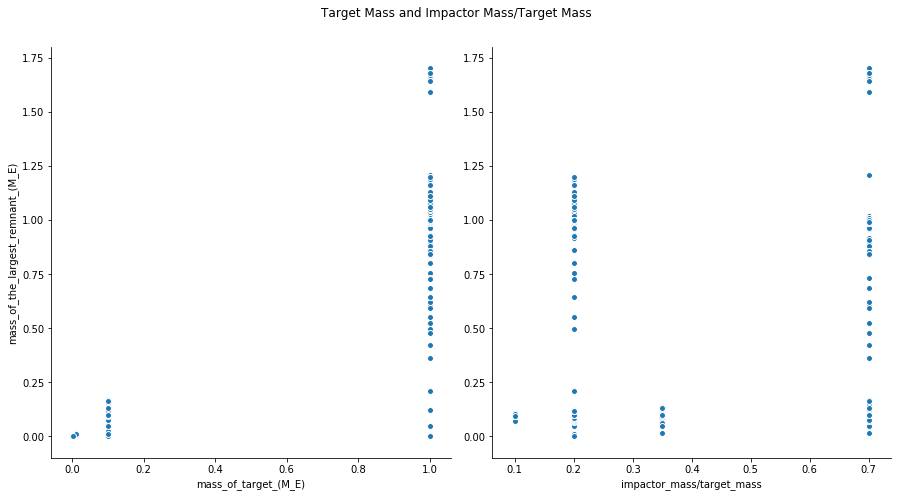

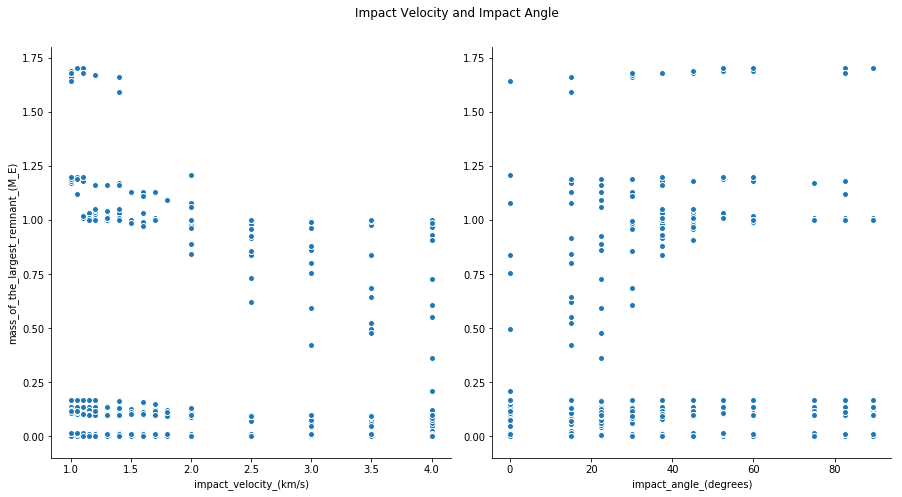

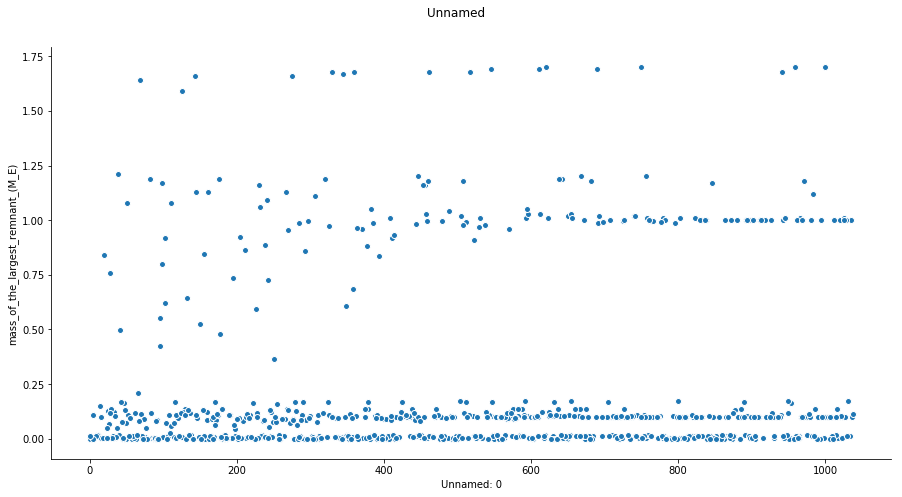

In [14]:
fig1 = sns.pairplot(impactdata, x_vars=['mass_of_target_(M_E)','impactor_mass/target_mass'], y_vars='mass_of_the_largest_remnant_(M_E)', size=7, aspect=0.9)
fig1 = fig1.fig
plt.subplots_adjust(top=0.9)
fig1.suptitle('Target Mass and Impactor Mass/Target Mass')
fig1.savefig('figures\sns fig1.png') 

fig2 = sns.pairplot(impactdata, x_vars=['impact_velocity_(km/s)','impact_angle_(degrees)'], y_vars='mass_of_the_largest_remnant_(M_E)', size=7, aspect=0.9)
fig2 = fig2.fig
plt.subplots_adjust(top=0.9)
fig2.suptitle('Impact Velocity and Impact Angle')
fig2.savefig('figures\sns fig2.png')

fig3 = sns.pairplot(impactdata, x_vars=['Unnamed: 0'], y_vars='mass_of_the_largest_remnant_(M_E)', size=7, aspect=1.8)
fig3 = fig3.fig
plt.subplots_adjust(top=0.9)
fig3.suptitle('Unnamed')
fig3.savefig('figures\sns fig3.png')

In [273]:
#To account for orders of magnitude mass differences, use fractional mass (mass/total mass)

X_visual = impactdata.loc[:,'mass_of_target_(M_E)':'impact_angle_(degrees)']
X_visual['Total Mass'] = X_visual['mass_of_target_(M_E)']+(X_visual['impactor_mass/target_mass']*X_visual['mass_of_target_(M_E)'])
y = impactdata.loc[:,'impact_angle_(degrees)':'mass_of_the_largest_remnant_(M_E)']

#X_visual['Adjusted Target Mass'] = X_visual['mass_of_target_(M_E)']/X_visual['Total Mass']
y['Adjusted Remnant Mass'] = y['mass_of_the_largest_remnant_(M_E)'].div(X_visual['Total Mass'],axis=0)
y = y.drop(y.columns[0:2],axis=1)

#print(y['Adjusted Remnant Mass'].sort_values(axis=0))

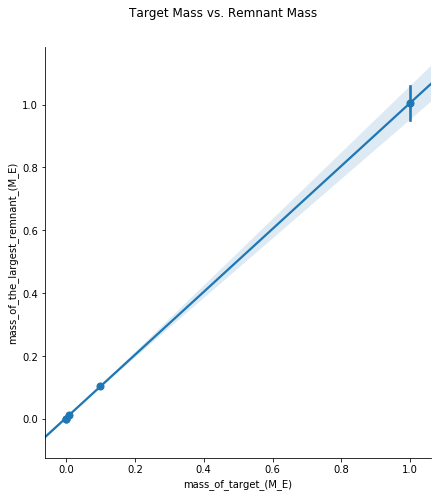

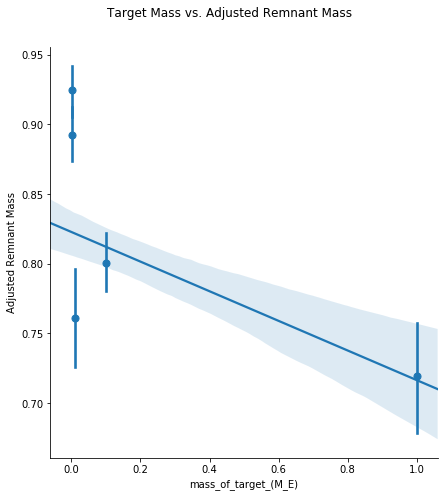

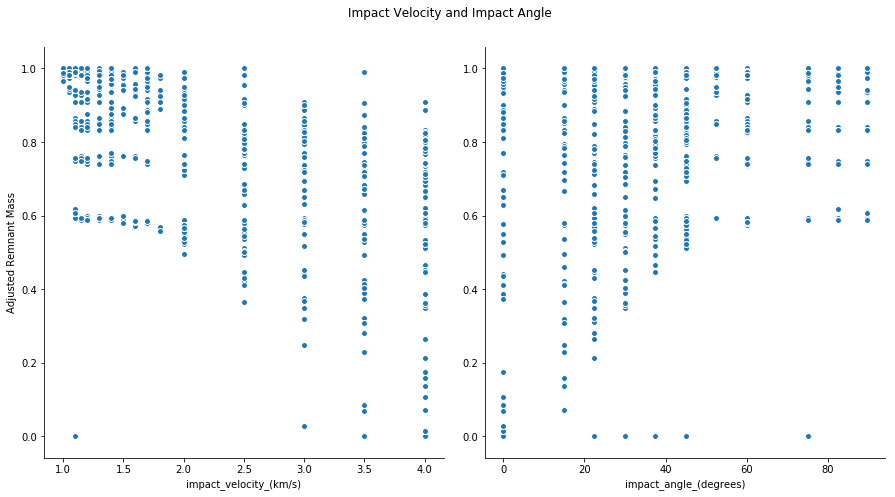

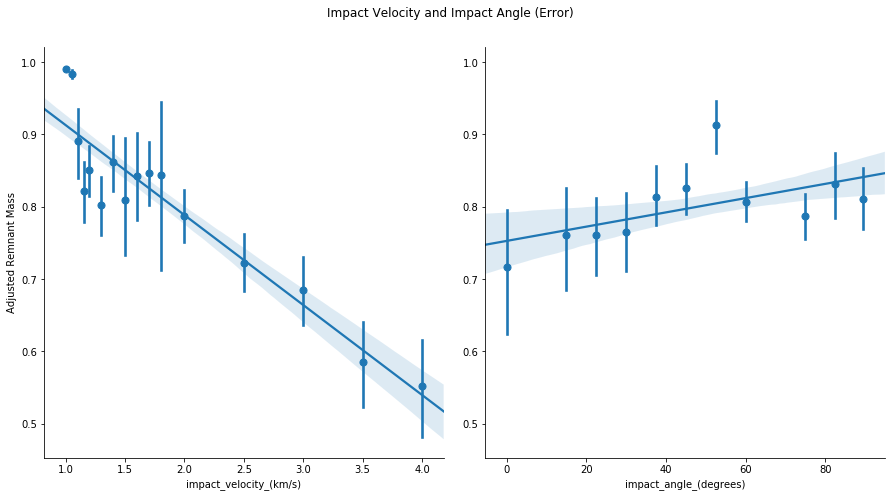

In [274]:
data_visual = X_visual.copy()
data_visual['Adjusted Remnant Mass'] = y['Adjusted Remnant Mass']
data_visual['mass_of_the_largest_remnant_(M_E)'] = impactdata['mass_of_the_largest_remnant_(M_E)']



#Use seaborn to verify that adjusted mass correct for order of magnitude error differences
fig6 = sns.pairplot(data_visual, x_vars=['mass_of_target_(M_E)'], y_vars=['mass_of_the_largest_remnant_(M_E)'], size=7, aspect=0.9, kind='reg', plot_kws=dict(x_estimator=np.mean))
fig6 = fig6.fig
plt.subplots_adjust(top=0.9)
fig6.suptitle('Target Mass vs. Remnant Mass')
fig6.savefig('figures\sns fig6.png') 

fig7 = sns.pairplot(data_visual, x_vars=['mass_of_target_(M_E)'], y_vars=['Adjusted Remnant Mass'], size=7, aspect=0.9, kind='reg', plot_kws=dict(x_estimator=np.mean))
fig7 = fig7.fig
plt.subplots_adjust(top=0.9)
fig7.suptitle('Target Mass vs. Adjusted Remnant Mass')
fig7.savefig('figures\sns fig7.png') 

#sns.residplot(data_visual['mass_of_target_(M_E)'], data_visual['mass_of_the_largest_remnant_(M_E)'], lowess=True, color="g")\
#sns.residplot(data_visual['Adjusted Target Mass'], data_visual['Adjusted Remnant Mass'], lowess=True, color="g")


#Plot adjusted masses versus other features
fig8 = sns.pairplot(data_visual, x_vars=['impact_velocity_(km/s)','impact_angle_(degrees)'], y_vars='Adjusted Remnant Mass', size=7, aspect=0.9)
fig8 = fig8.fig
plt.subplots_adjust(top=0.9)
fig8.suptitle('Impact Velocity and Impact Angle')
fig8.savefig('figures\sns fig8.png')

fig9 = sns.pairplot(data_visual, x_vars=['impact_velocity_(km/s)','impact_angle_(degrees)'], y_vars='Adjusted Remnant Mass', size=7, aspect=0.9, kind='reg', plot_kws=dict(x_estimator=np.mean))
fig9 = fig9.fig
plt.subplots_adjust(top=0.9)
fig9.suptitle('Impact Velocity and Impact Angle (Error)')
fig9.savefig('figures\sns fig9.png')

In [17]:
#Finds mean of scores list for both the 100-sample model, 20-sample model, 40-sample model, 10-sample model (100 iterations each)
#Smaller is better?
lm, testX, testy, testsamples, scoresfinal, coeffdict = linmodel(600,100,X_visual,y)
print("Number of Test Samples :", testsamples)
print("Average R^2 :",scoresfinal)
print("Coefficients :",coeffdict)
#linmodel(400,100,X_visual,y)
#linmodel(200,100,X_visual,y)
#linmodel(100,100,X_visual,y)
#linmodel(10,100,X_visual,y)

Number of Test Samples : 600
Average R^2 : 0.749833039567
Coefficients : {'mass_of_target_(M_E)': -0.092936240675883935, 'impactor_mass/target_mass': -0.13154840890752367, 'impact_velocity_(km/s)': -0.12554666654799504, 'impact_angle_(degrees)': -0.00061034188964247875, 'Total Mass': 0.026698869602951737, 'Adjusted Target Mass': 0.57848911602273789}


# Actual Machine Learning Stuff

## Preprocessing

In [169]:
#Preprocessing
X = impactdata.loc[:,'mass_of_target_(M_E)':'impact_angle_(degrees)']
X['Total Mass'] = X['mass_of_target_(M_E)']+(X['impactor_mass/target_mass']*X['mass_of_target_(M_E)'])
y = impactdata.loc[:,'impact_angle_(degrees)':'mass_of_the_largest_remnant_(M_E)']
#y = impactdata['mass_of_the_largest_remnant_(M_E)']

#X['Adjusted Target Mass'] = X['mass_of_target_(M_E)']/X['Total Mass']
#X = X.drop(X.columns[0],axis=1)

y['Adjusted Remnant Mass'] = y['mass_of_the_largest_remnant_(M_E)']/X['Total Mass']
y = y.drop(y.columns[0:2],axis=1)

print(X.describe())
print(y.describe())

       mass_of_target_(M_E)  impactor_mass/target_mass  \
count            779.000000                 779.000000   
mean               0.241432                   0.362067   
std                0.380685                   0.234073   
min                0.000100                   0.100000   
25%                0.010000                   0.200000   
50%                0.100000                   0.200000   
75%                0.100000                   0.700000   
max                1.000000                   0.700000   

       impact_velocity_(km/s)  impact_angle_(degrees)  Total Mass  
count              779.000000              779.000000  779.000000  
mean                 1.930295               44.993453    0.342491  
std                  0.973244               24.764185    0.557879  
min                  1.000000                0.100000    0.000120  
25%                  1.150000               22.500000    0.012000  
50%                  1.400000               45.000000    0.120000  
7

In [171]:
#Call datascale function
X_0 = X.copy()
#X_0['Total Mass'] = np.log10(X_0['Total Mass'])
X_0, scaler_0 = datascale(X_0)

     mass_of_target_(M_E)  impactor_mass/target_mass  impact_velocity_(km/s)  \
774              1.993920                  -0.692823                0.071667   
775             -0.634348                  -0.692823               -0.853669   
776             -0.631982                  -0.692823                2.127970   
777             -0.371758                   1.444639               -0.545224   
778              1.993920                  -0.692823                0.071667   

     impact_angle_(degrees)  Total Mass  
774               -0.605838    1.538076  
775               -0.302787   -0.614095  
776               -0.302787   -0.612158  
777               -0.908889   -0.309389  
778                0.606367    1.538076  


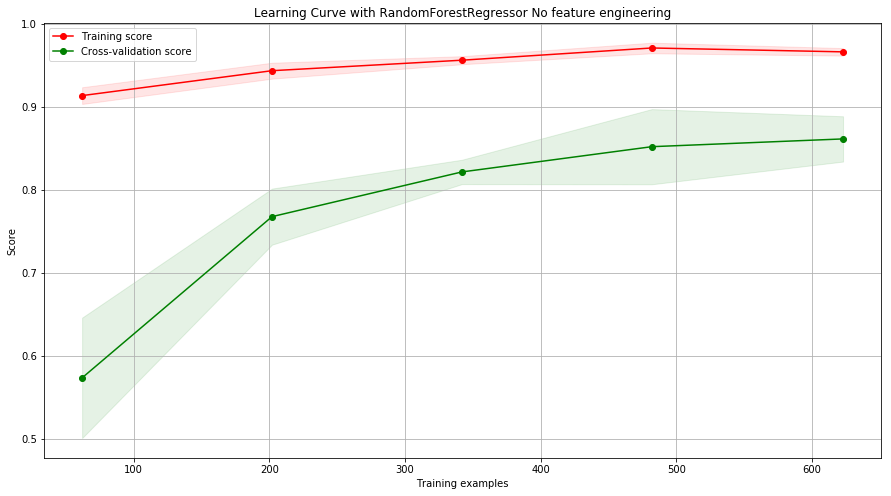

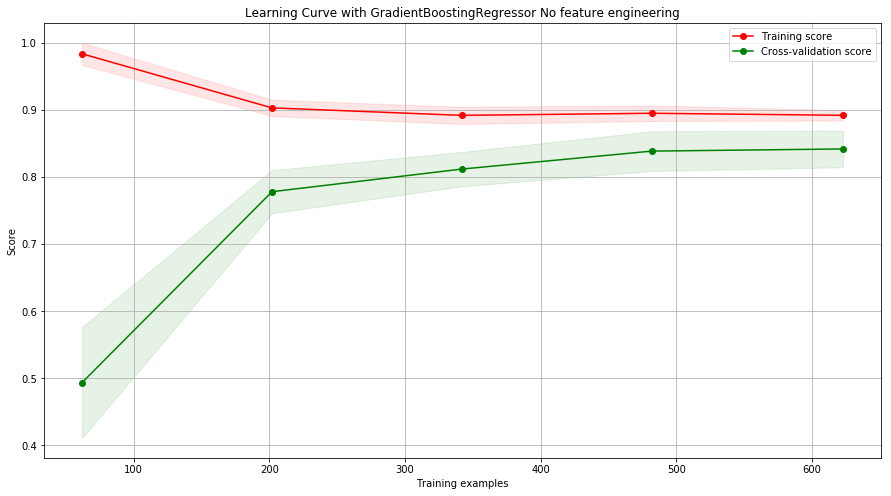

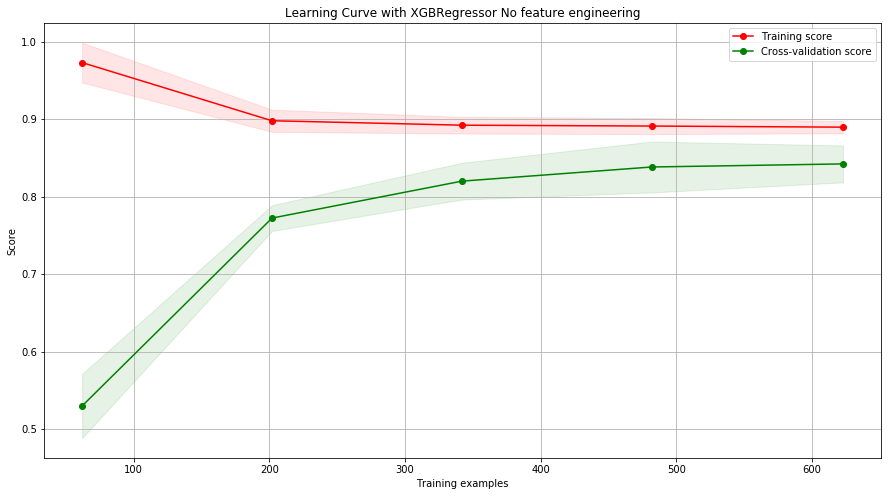

In [96]:
#Plot learning curves for dataset
learning_curve_plot(RandomForestRegressor(),X_0,y,"No feature engineering")
learning_curve_plot(GradientBoostingRegressor(),X_0,y,"No feature engineering")
learning_curve_plot(XGBRegressor(),X_0,y,"No feature engineering")

In [172]:
#Split data into test/train sets
trainX_0, testX_0, trainy_0, testy_0 = train_test_split(X_0, y, test_size=0.75, random_state=42)

## Hyperparameter Optimization

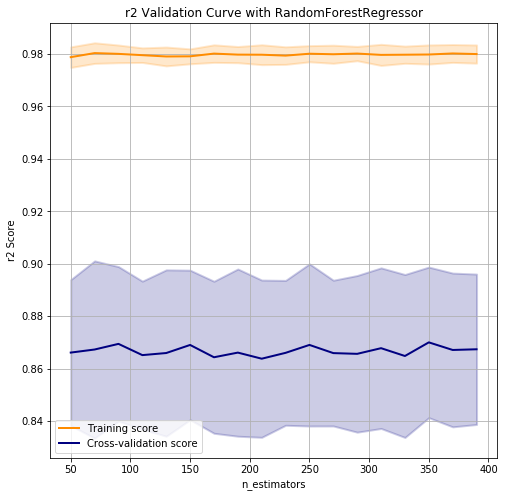

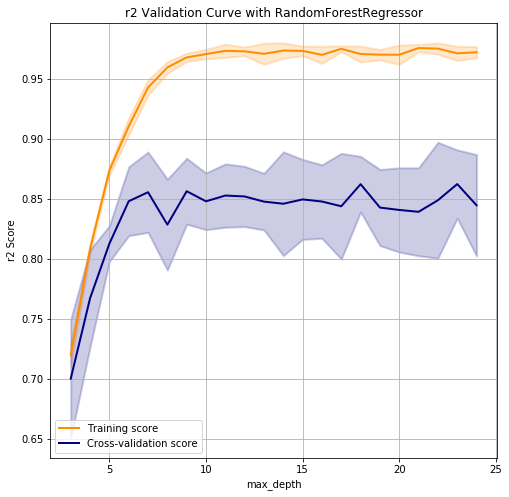

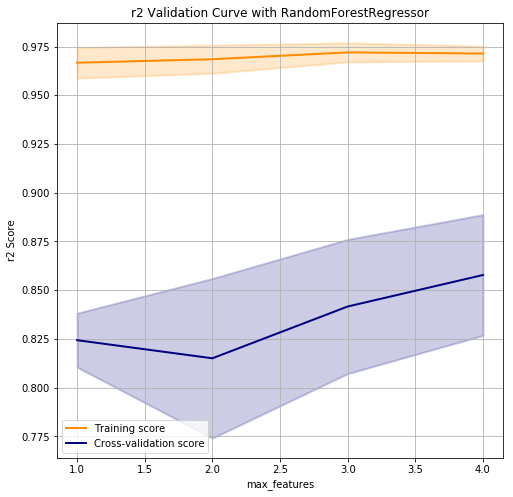

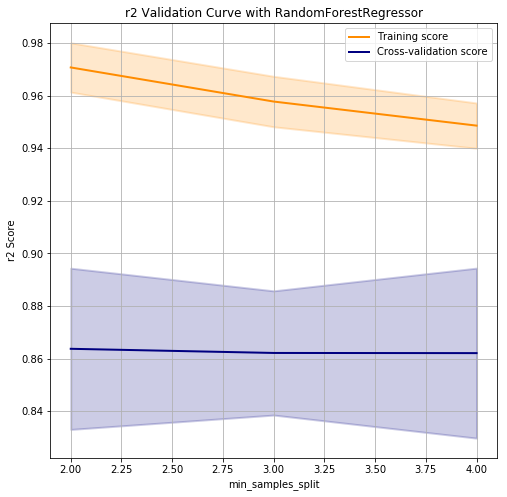

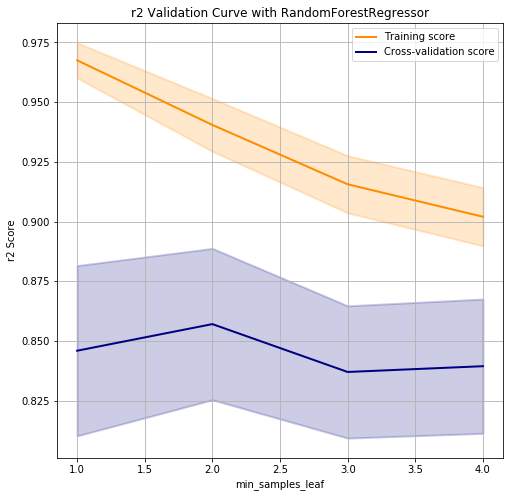

In [125]:
######Call validation curve functions for each hyperparameter (only needed to narrow ranges)

#Random Forest
valid_curve_plot(X_0,y,RandomForestRegressor(),"n_estimators",np.arange(50,400,20), "r2")
valid_curve_plot(X_0,y,RandomForestRegressor(),"max_depth", np.arange(3,25), "r2")
valid_curve_plot(X_0,y,RandomForestRegressor(),"max_features", np.arange(1, len(X_0.columns)), "r2")
valid_curve_plot(X_0,y,RandomForestRegressor(),"min_samples_split", np.arange(2, len(X_0.columns)), "r2")
valid_curve_plot(X_0,y,RandomForestRegressor(),"min_samples_leaf", np.arange(1, len(X_0.columns)), "r2")

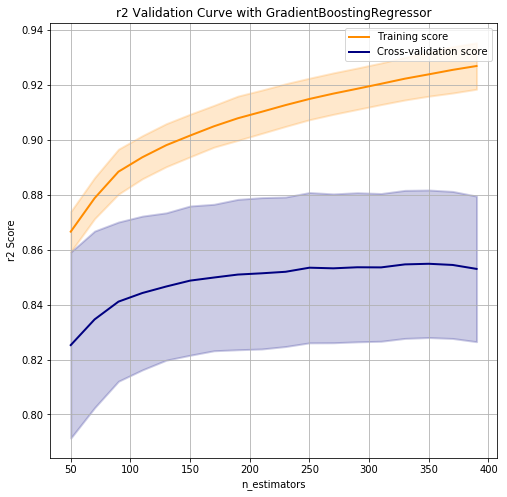

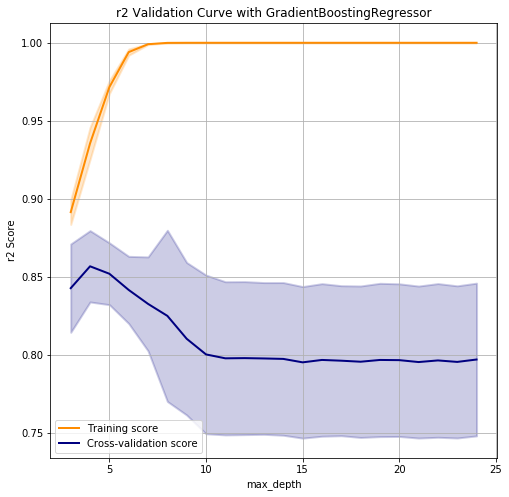

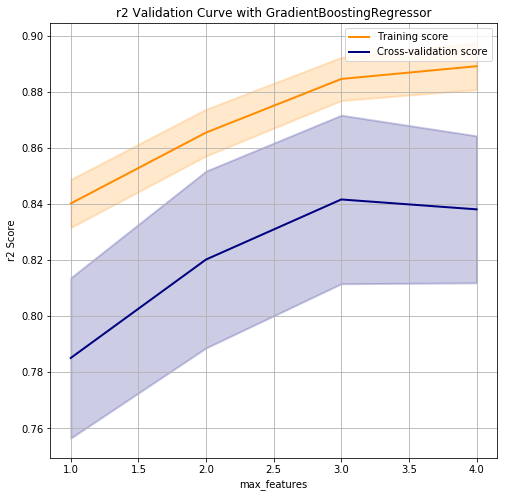

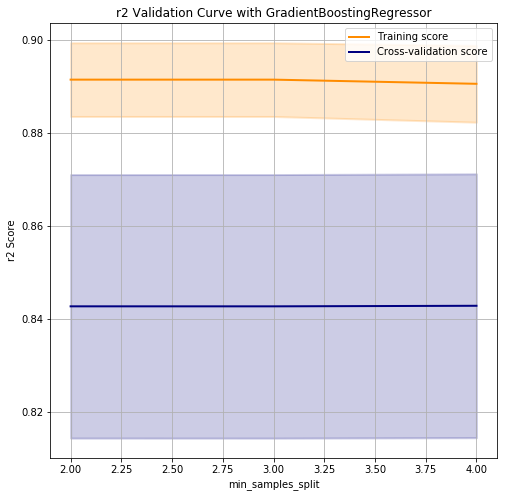

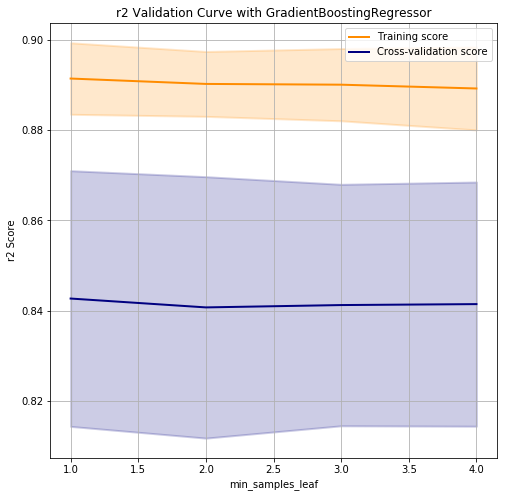

In [126]:
#Gradient Boosting
valid_curve_plot(X_0,y,GradientBoostingRegressor(),"n_estimators",np.arange(50,400,20), "r2")
valid_curve_plot(X_0,y,GradientBoostingRegressor(),"max_depth", np.arange(3,25), "r2")
valid_curve_plot(X_0,y,GradientBoostingRegressor(),"max_features", np.arange(1, len(X_0.columns)), "r2")
valid_curve_plot(X_0,y,GradientBoostingRegressor(),"min_samples_split", np.arange(2, len(X_0.columns)), "r2")
valid_curve_plot(X_0,y,GradientBoostingRegressor(),"min_samples_leaf", np.arange(1, len(X_0.columns)), "r2")

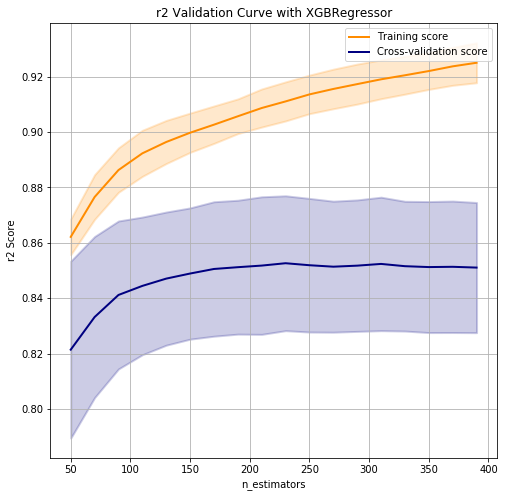

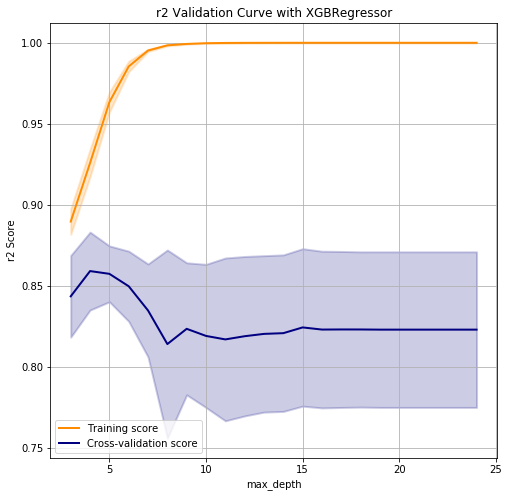

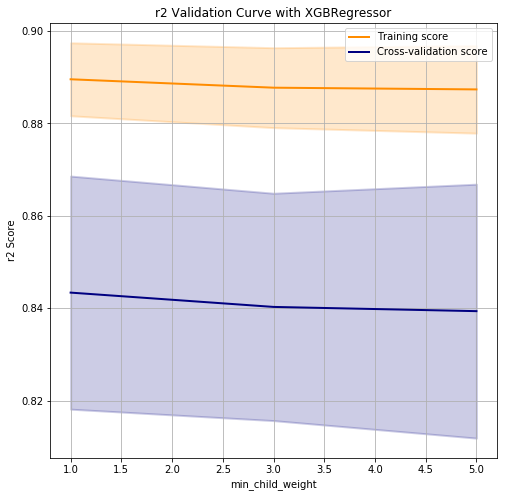

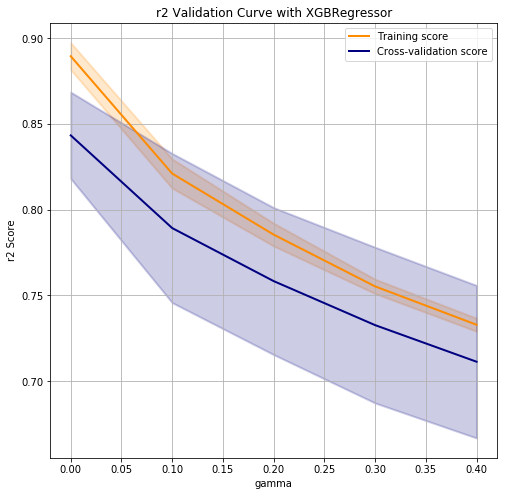

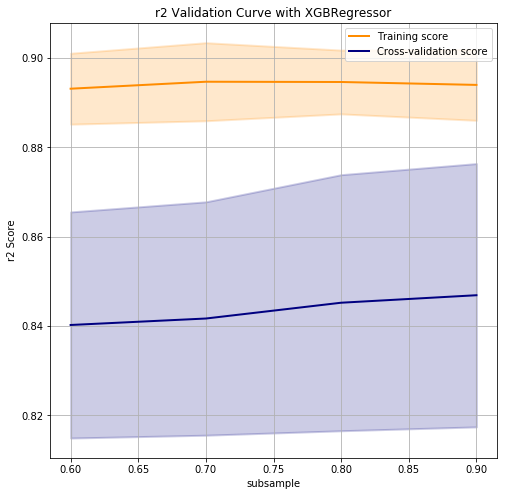

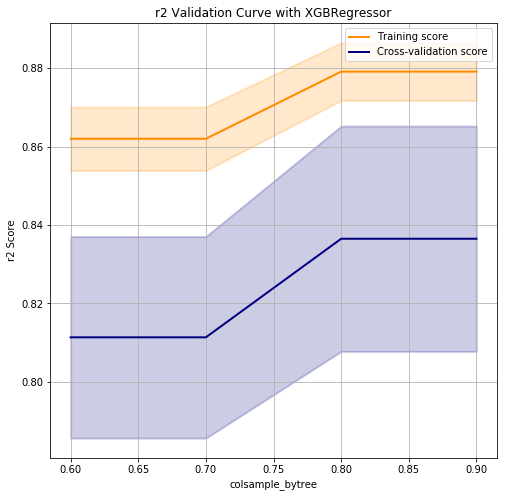

In [127]:
#XGBoost
valid_curve_plot(X_0,y,XGBRegressor(),"n_estimators", np.arange(50,400,20), "r2")
valid_curve_plot(X_0,y,XGBRegressor(),"max_depth", np.arange(3,25), "r2")
valid_curve_plot(X_0,y,XGBRegressor(),"min_child_weight", np.arange(1,6,2), "r2")
valid_curve_plot(X_0,y,XGBRegressor(),"gamma", [i/10.0 for i in range(0,5)], "r2")
valid_curve_plot(X_0,y,XGBRegressor(),"subsample", [i/10.0 for i in range(6,10)], "r2")
valid_curve_plot(X_0,y,XGBRegressor(),"colsample_bytree", [i/10.0 for i in range(6,10)], "r2")


## Model Training

In [230]:
#Call regressor functions with a set of data

RFregressor_0_MAE,RF_MAEscores_0 = RFregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_absolute_error")
RFregressor_0_R2,RF_R2scores_0 = RFregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "r2")
RFregressor_0_MSLE,RF_MSLEscores_0 = RFregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_squared_log_error")
print()

GBregressor_0_MAE,GB_MAEscores_0 = GBregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_absolute_error")
GBregressor_0_R2,GB_R2scores_0 = GBregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "r2")
GBregressor_0_MSLE,GB_MSLEscores_0 = GBregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_squared_log_error")
print()

XGBregressor_0_MAE,XGB_MAEscores_0 = XGBregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_absolute_error")
XGBregressor_0_R2,XGB_R2scores_0 = XGBregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "r2")
XGBregressor_0_MSLE,XGB_MSLEscores_0 = XGBregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_squared_log_error")
print()

SVRregressor_0_MAE,SVR_MAEscores_0 = SVRregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_absolute_error")
SVRregressor_0_R2,SVR_R2scores_0 = SVRregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "r2")
SVRregressor_0_MSLE,SVR_MSLEscores_0 = SVRregressorFunct(X_0, y, trainX_0, testX_0, trainy_0, testy_0, "neg_mean_squared_log_error")

The best parameters are {'n_estimators': 178, 'max_features': 4, 'max_depth': 12} with a score of -0.0338
Mean RF neg_mean_absolute_error (train split): -0.0673056506041
Mean RF neg_mean_absolute_error (test split): -0.0348343065006
The best parameters are {'n_estimators': 153, 'max_features': 4, 'max_depth': 18} with a score of 0.8693
Mean RF r2 (train split): 0.687115518492
Mean RF r2 (test split): 0.858592106112
The best parameters are {'n_estimators': 398, 'max_features': 4, 'max_depth': 23} with a score of -0.0028
Mean RF neg_mean_squared_log_error (train split): -0.00732509483964
Mean RF neg_mean_squared_log_error (test split): -0.002605192112

The best parameters are {'n_estimators': 206, 'max_features': 3, 'max_depth': 9} with a score of -0.0344
Mean GB neg_mean_absolute_error (train split): -0.0682406423965
Mean GB neg_mean_absolute_error (test split): -0.0326971266474
The best parameters are {'n_estimators': 182, 'max_features': 3, 'max_depth': 4} with a score of 0.8579
Mean 

In [231]:
#Comparison with default models (ignore SVR)

RFregressor_def = RandomForestRegressor()
RFregressor_def.fit(trainX_0, trainy_0.values.ravel())
RF_MAEscores_train_def = cross_val_score(RFregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean RF MAE (train split):",np.mean(RF_MAEscores_train_def))
RF_MAEscores_test_def = cross_val_score(RFregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean RF MAE (test split):",np.mean(RF_MAEscores_test_def))

RF_R2scores_train_def = cross_val_score(RFregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="r2")
print("Mean RF R2 (train split):",np.mean(RF_R2scores_train_def))
RF_R2scores_test_def = cross_val_score(RFregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="r2")
print("Mean RF R2 (test split):",np.mean(RF_R2scores_test_def))

RF_MSLEscores_train_def = cross_val_score(RFregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean RF MSLE (train split):",np.mean(RF_MSLEscores_train_def))
RF_MSLEscores_test_def = cross_val_score(RFregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean RF MSLE (test split):",np.mean(RF_MSLEscores_test_def))
print()

GBregressor_def = GradientBoostingRegressor()
GBregressor_def.fit(trainX_0, trainy_0.values.ravel())
GB_MAEscores_train_def = cross_val_score(GBregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean GB MAE (train split):",np.mean(GB_MAEscores_train_def))
GB_MAEscores_test_def = cross_val_score(GBregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean GB MAE (test split):",np.mean(GB_MAEscores_test_def))

GB_R2scores_train_def = cross_val_score(GBregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="r2")
print("Mean GB R2 (train split):",np.mean(GB_R2scores_train_def))
GB_R2scores_test_def = cross_val_score(GBregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="r2")
print("Mean GB R2 (test split):",np.mean(GB_R2scores_test_def))

GB_MSLEscores_train_def = cross_val_score(GBregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean GB MSLE (train split):",np.mean(GB_MSLEscores_train_def))
GB_MSLEscores_test_def = cross_val_score(GBregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean GB MSLE (test split):",np.mean(GB_MSLEscores_test_def))
print()

XGBregressor_def = XGBRegressor()
XGBregressor_def.fit(trainX_0, trainy_0.values.ravel())
XGB_MAEscores_train_def = cross_val_score(XGBregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean XGB MAE (train split):",np.mean(XGB_MAEscores_train_def))
XGB_MAEscores_test_def = cross_val_score(XGBregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean XGB MAE (test split):",np.mean(XGB_MAEscores_test_def))

XGB_R2scores_train_def = cross_val_score(XGBregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="r2")
print("Mean XGB R2 (train split):",np.mean(XGB_R2scores_train_def))
XGB_R2scores_test_def = cross_val_score(XGBregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="r2")
print("Mean XGB R2 (test split):",np.mean(XGB_R2scores_test_def))

XGB_MSLEscores_train_def = cross_val_score(XGBregressor_def, trainX_0, trainy_0.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean XGB MSLE (train split):",np.mean(XGB_MSLEscores_train_def))
XGB_MSLEscores_test_def = cross_val_score(XGBregressor_def, testX_0, testy_0.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean XGB MSLE (test split):",np.mean(XGB_MSLEscores_test_def))



Mean RF MAE (train split): -0.0666249489869
Mean RF MAE (test split): -0.035926775326
Mean RF R2 (train split): 0.632920331639
Mean RF R2 (test split): 0.833336300699
Mean RF MSLE (train split): -0.00763952057873
Mean RF MSLE (test split): -0.00296361677713

Mean GB MAE (train split): -0.0743162954256
Mean GB MAE (test split): -0.0480832620555
Mean GB R2 (train split): 0.642097351311
Mean GB R2 (test split): 0.833879236492
Mean GB MSLE (train split): -0.0085161599813
Mean GB MSLE (test split): -0.00297972170934

Mean XGB MAE (train split): -0.0751931688442
Mean XGB MAE (test split): -0.0479406480002
Mean XGB R2 (train split): 0.636446852365
Mean XGB R2 (test split): 0.834470864345
Mean XGB MSLE (train split): -0.00855317298911
Mean XGB MSLE (test split): -0.00296305991222


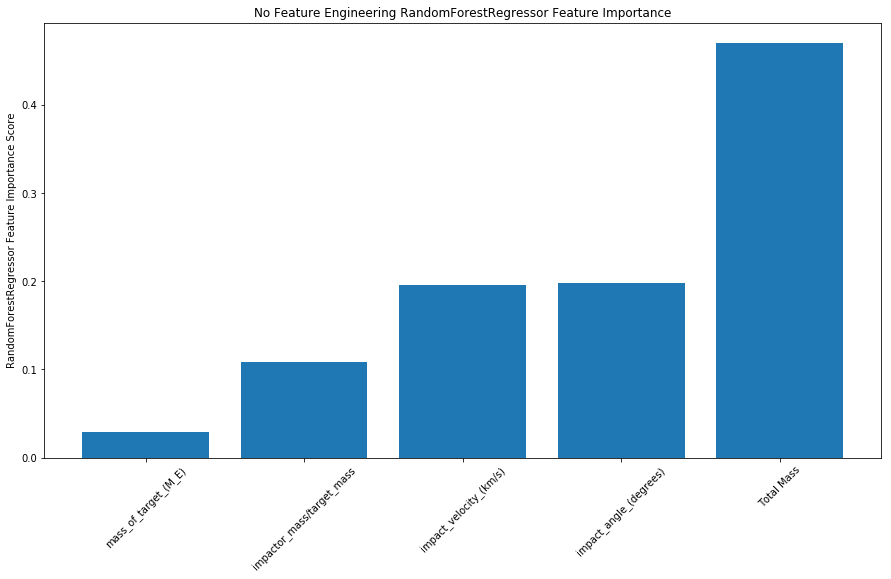

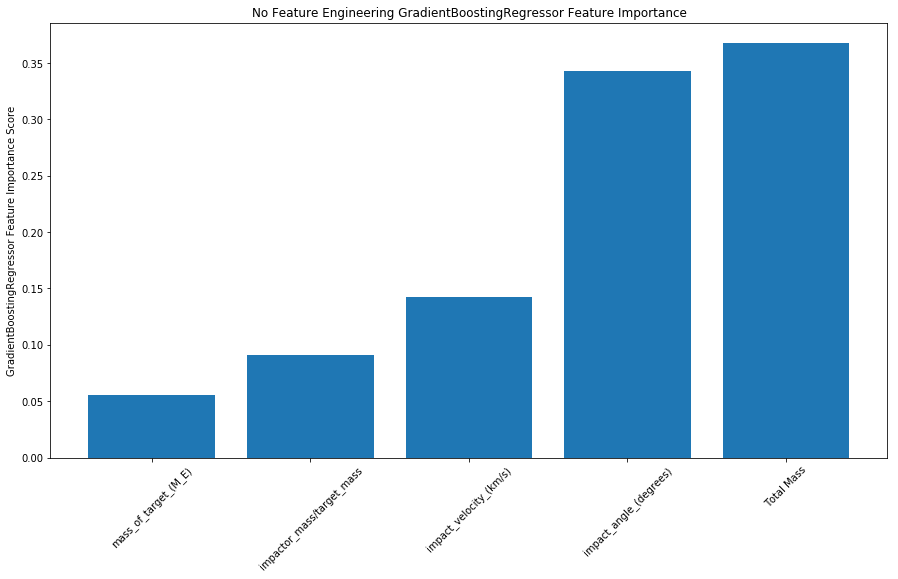

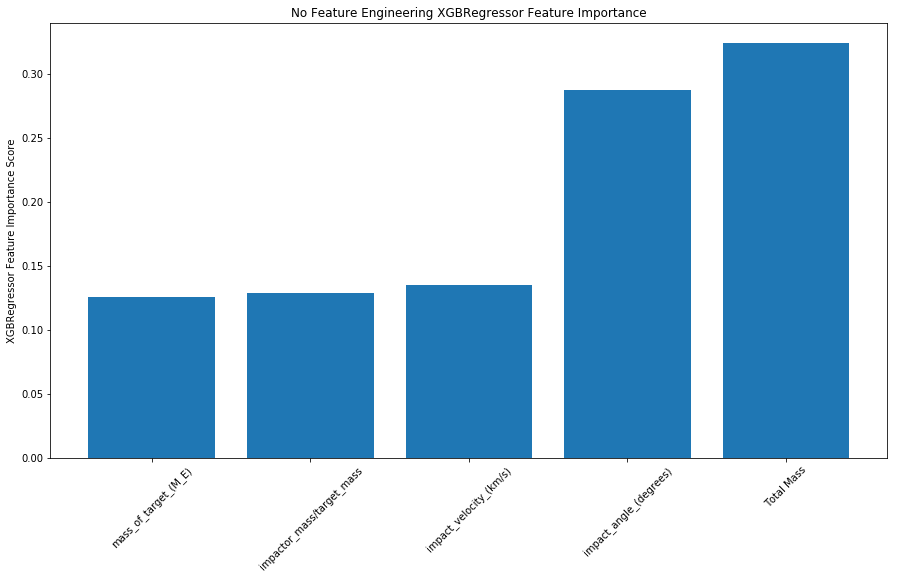

In [175]:
#Plot and compare feature importance between regressors (MSLE)
regressor_list = [RFregressor_0_MSLE,GBregressor_0_MSLE,XGBregressor_0_MSLE]
feature_0 = 'No Feature Engineering'

for regressor in regressor_list:
    feat_imp_plot(regressor,X_0,feature_0)

No Feature Engineering
RandomForestRegressor: 0.968725767256
GradientBoostingRegressor: 0.94186217715
XGBRegressor: 0.948833995438
SVR: 0.959087920668


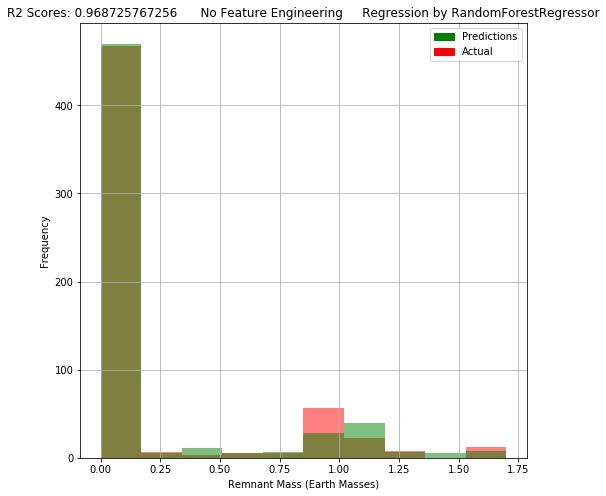

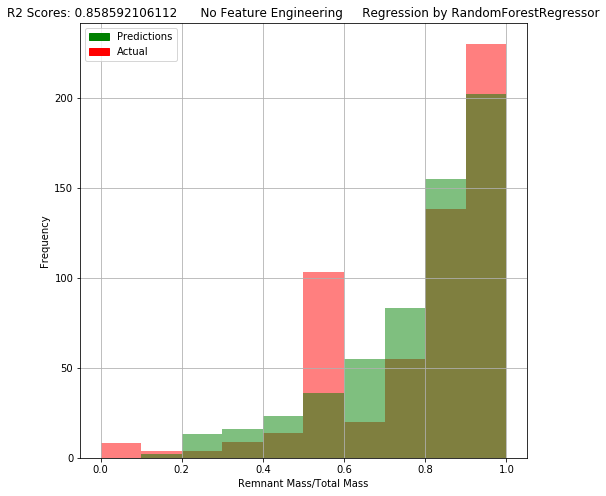

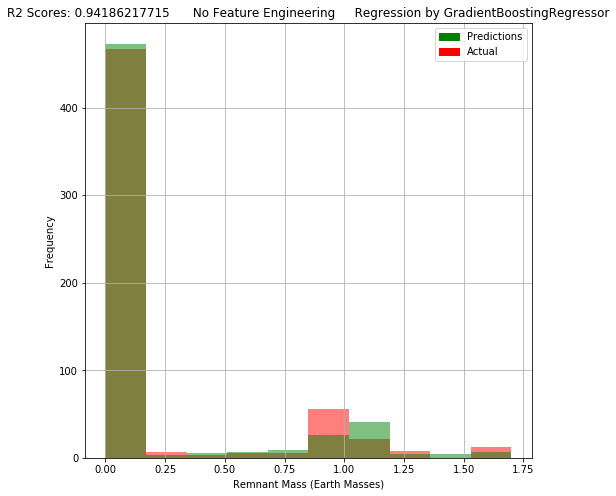

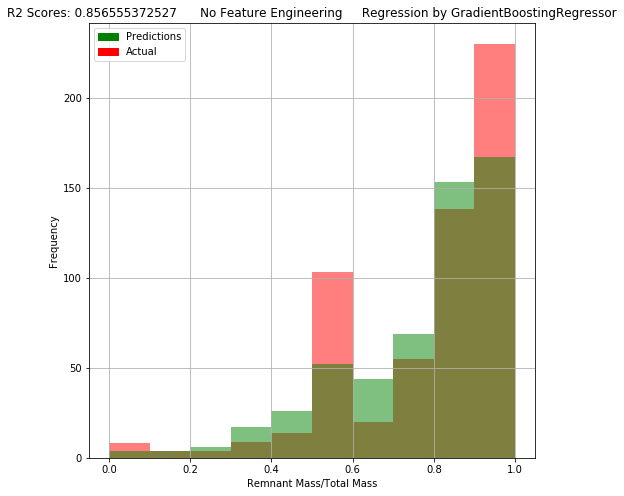

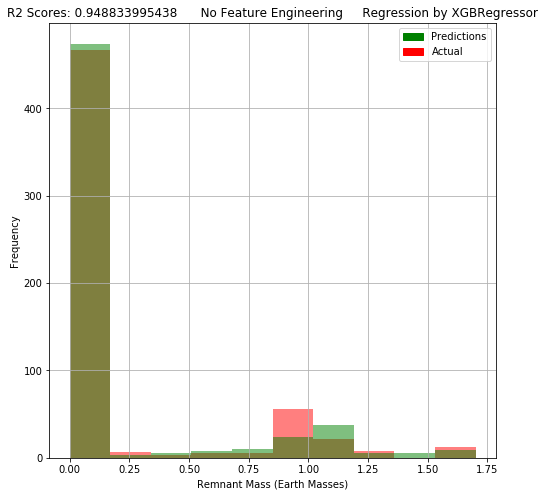

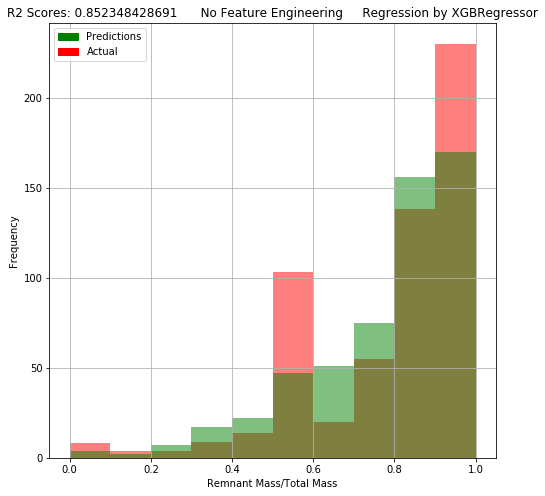

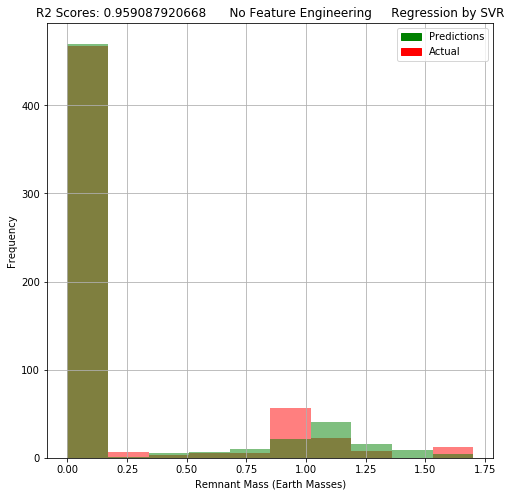

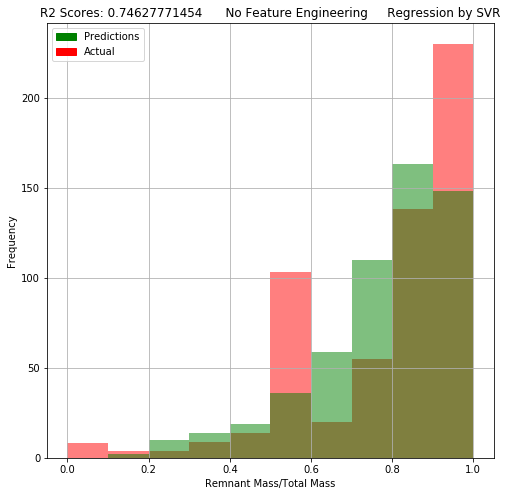

In [282]:
R2regressor_list_0 = [RFregressor_0_R2,GBregressor_0_R2,XGBregressor_0_R2,SVRregressor_0_R2]
R2scores_list_0 = [RF_R2scores_0,GB_R2scores_0,XGB_R2scores_0,SVR_R2scores_0]
R2scores_list_final_0 = []

#Model effectiveness before feature engineering
print(feature_0)
for i in range(len(R2regressor_list_0)):
    R2scores_list_final_0.append(plotfunct(R2regressor_list_0[i],R2scores_list_0[i],feature_0,testX_0,testy_0,"R2",scaler_0))

No Feature Engineering
RandomForestRegressor: 0.0256450189028
GradientBoostingRegressor: 0.0268806067644
XGBRegressor: 0.0288720198594
SVR: 0.0324182541839


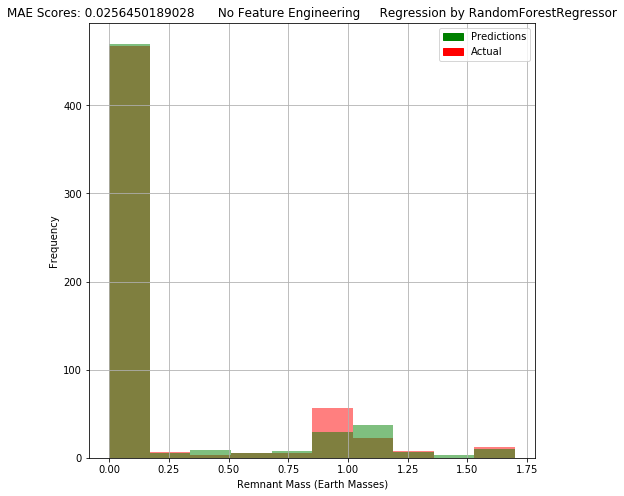

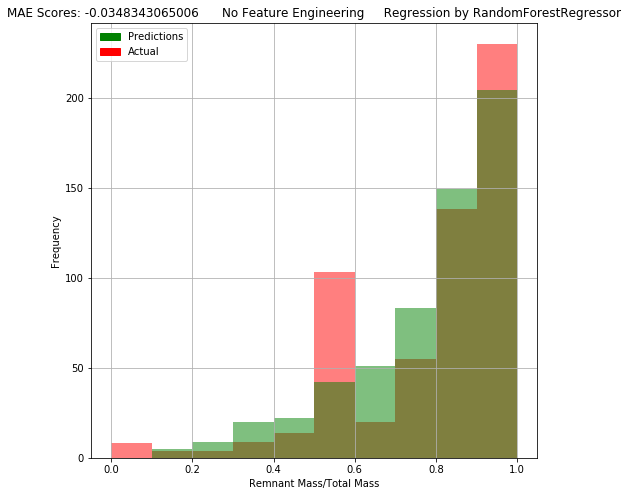

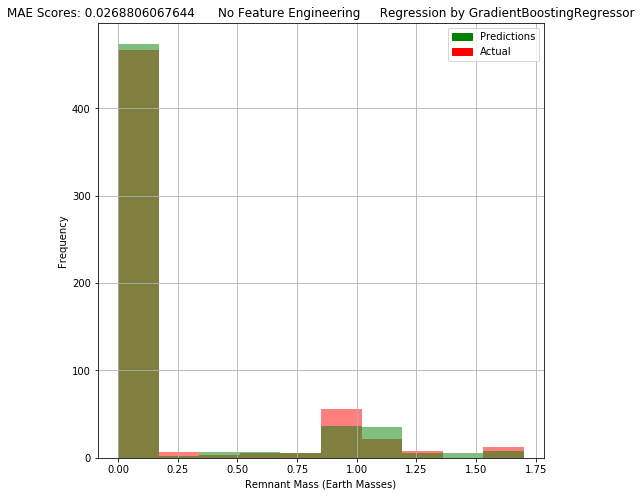

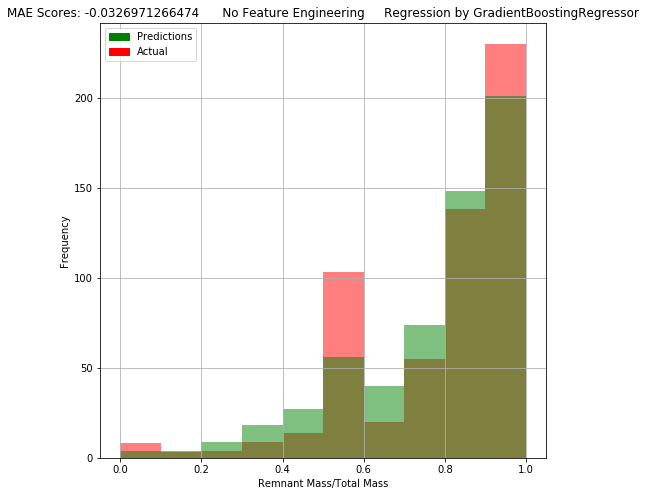

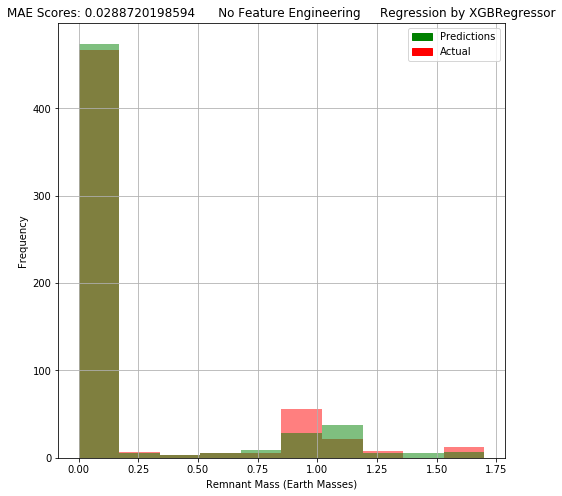

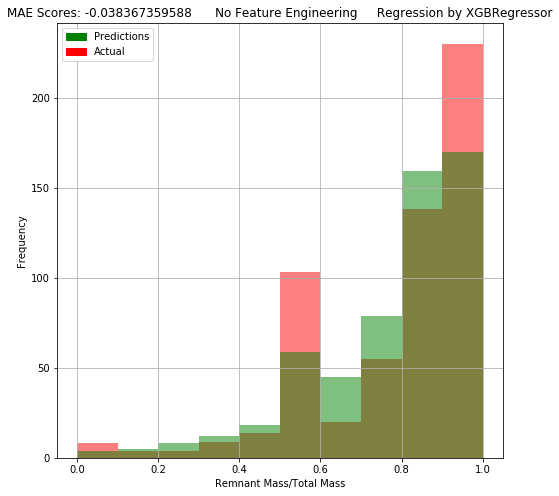

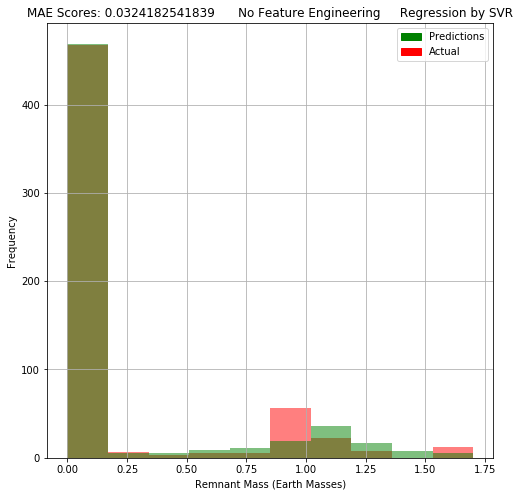

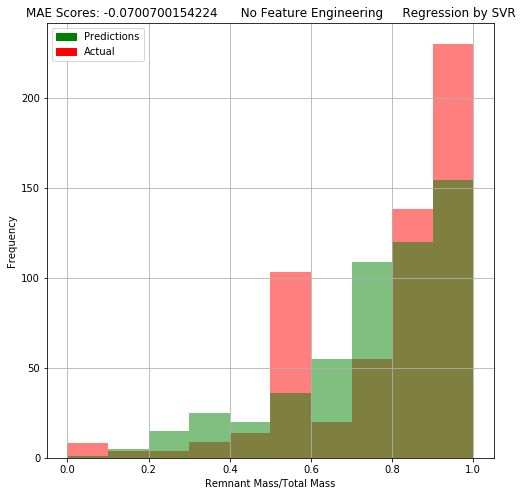

In [283]:
MAEregressor_list_0 = [RFregressor_0_MAE,GBregressor_0_MAE,XGBregressor_0_MAE,SVRregressor_0_MAE]
MAEscores_list_0 = [RF_MAEscores_0,GB_MAEscores_0,XGB_MAEscores_0,SVR_MAEscores_0]
MAEscores_list_final_0 = []

#Model effectiveness before feature engineering
feature_0 = 'No Feature Engineering'
print(feature_0)
for i in range(len(MAEregressor_list_0)):
    MAEscores_list_final_0.append(plotfunct(MAEregressor_list_0[i],MAEscores_list_0[i],feature_0,testX_0,testy_0,"MAE",scaler_0))

No Feature Engineering
RandomForestRegressor: 0.00207056986512
GradientBoostingRegressor: 0.00472113805424
XGBRegressor: 0.00204721282979
SVR: 0.00194430504045


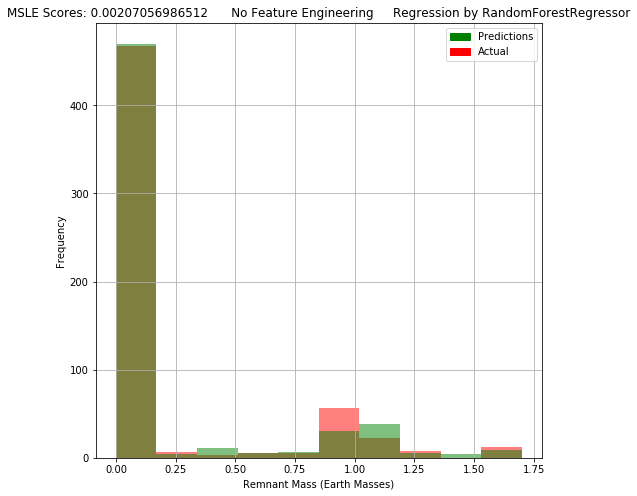

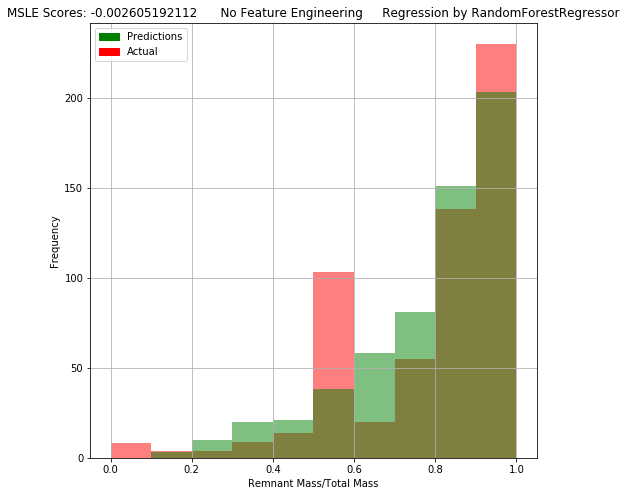

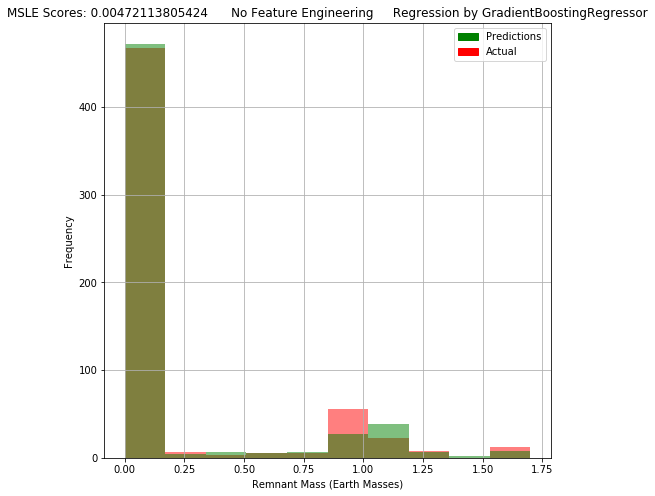

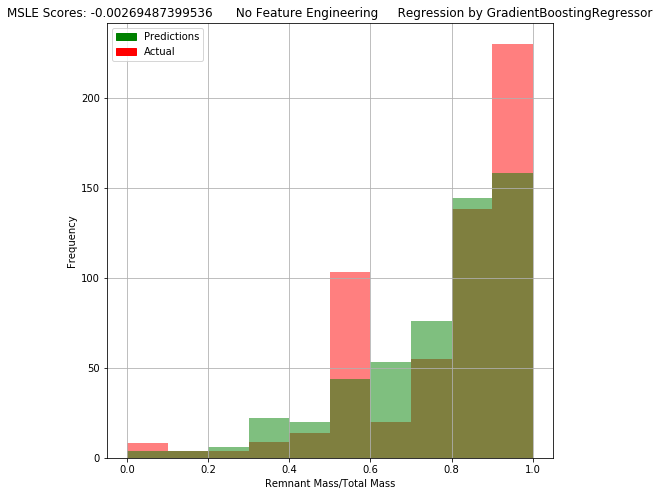

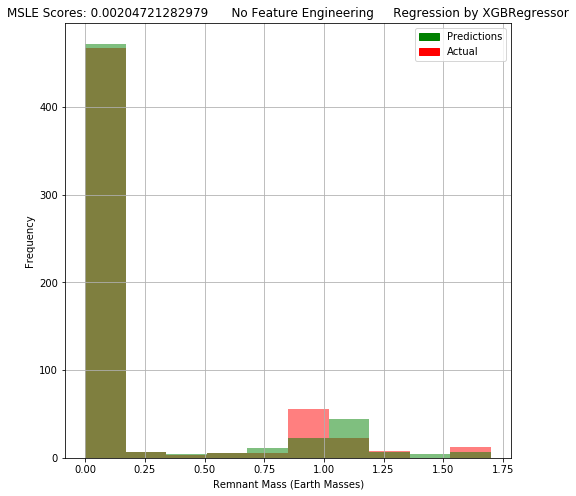

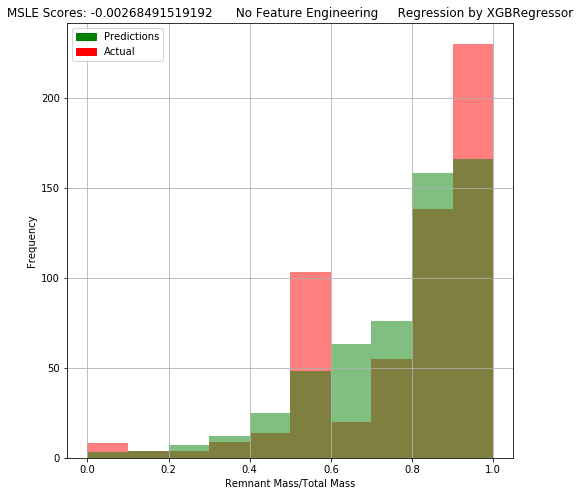

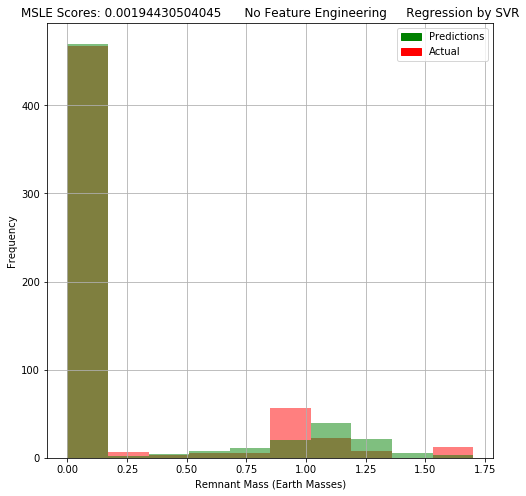

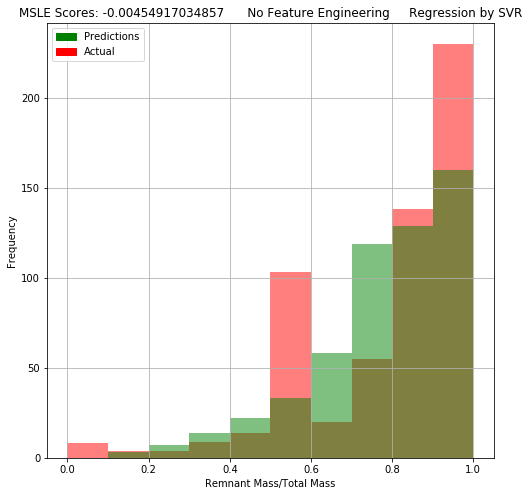

In [284]:
MSLEregressor_list_0 = [RFregressor_0_MSLE,GBregressor_0_MSLE,XGBregressor_0_MSLE,SVRregressor_0_MSLE]
MSLEscores_list_0 = [RF_MSLEscores_0,GB_MSLEscores_0,XGB_MSLEscores_0,SVR_MSLEscores_0]
MSLEscores_list_final_0 = []

#Model effectiveness before feature engineering
feature_0 = 'No Feature Engineering'
print(feature_0)
for i in range(len(MSLEregressor_list_0)):
    MSLEscores_list_final_0.append(plotfunct(MSLEregressor_list_0[i],MSLEscores_list_0[i],feature_0,testX_0,testy_0,"MSLE",scaler_0))

# Feature Engineering

In [277]:
############ Feature Engineering
#Try out energy-esque consideration (Impactor Mass*(Impact velocity)^2)
#Also try converting impact angle to sin(angle) (in radians)

############## Take log10 of energy and total mass to avoid problems with OoM

X_1 = X.copy()
X_1['mass_of_target_(M_E)'] = impactdata['mass_of_target_(M_E)']
X_1['Impactor Mass*(Impact velocity)^2'] = (X_1['mass_of_target_(M_E)']*X_1['impactor_mass/target_mass'])*(X_1['impact_velocity_(km/s)'])**2
X_1['sin(impact angle)'] = np.sin(np.deg2rad(X_1['impact_angle_(degrees)']))

X_1['Total Mass'] = np.log10(X_1['Total Mass'])
X_1['Impactor Mass*(Impact velocity)^2'] = np.log10(X_1['Impactor Mass*(Impact velocity)^2'])
    
#X_1.drop(['mass_of_target_(M_E)'],axis=1,inplace=True)
print(X_1.describe())
print(y.describe())

       mass_of_target_(M_E)  impactor_mass/target_mass  \
count            779.000000                 779.000000   
mean               0.241432                   0.362067   
std                0.380685                   0.234073   
min                0.000100                   0.100000   
25%                0.010000                   0.200000   
50%                0.100000                   0.200000   
75%                0.100000                   0.700000   
max                1.000000                   0.700000   

       impact_velocity_(km/s)  impact_angle_(degrees)  Total Mass  \
count              779.000000              779.000000  779.000000   
mean                 1.930295               44.993453   -1.358390   
std                  0.973244               24.764185    1.207924   
min                  1.000000                0.100000   -3.920819   
25%                  1.150000               22.500000   -1.920819   
50%                  1.400000               45.000000   -0.9208

In [187]:
#Scale data
X_1, scaler_1 = datascale(X_1)

     mass_of_target_(M_E)  impactor_mass/target_mass  impact_velocity_(km/s)  \
774              1.993920                  -0.692823                0.071667   
775             -0.634348                  -0.692823               -0.853669   
776             -0.631982                  -0.692823                2.127970   
777             -0.371758                   1.444639               -0.545224   
778              1.993920                  -0.692823                0.071667   

     impact_angle_(degrees)  Total Mass  Impactor Mass*(Impact velocity)^2  \
774               -0.605838    1.538076                           0.194099   
775               -0.302787   -0.614095                          -0.341373   
776               -0.302787   -0.612158                          -0.339247   
777               -0.908889   -0.309389                          -0.249553   
778                0.606367    1.538076                           0.194099   

     sin(impact angle)  
774          -0.490998  


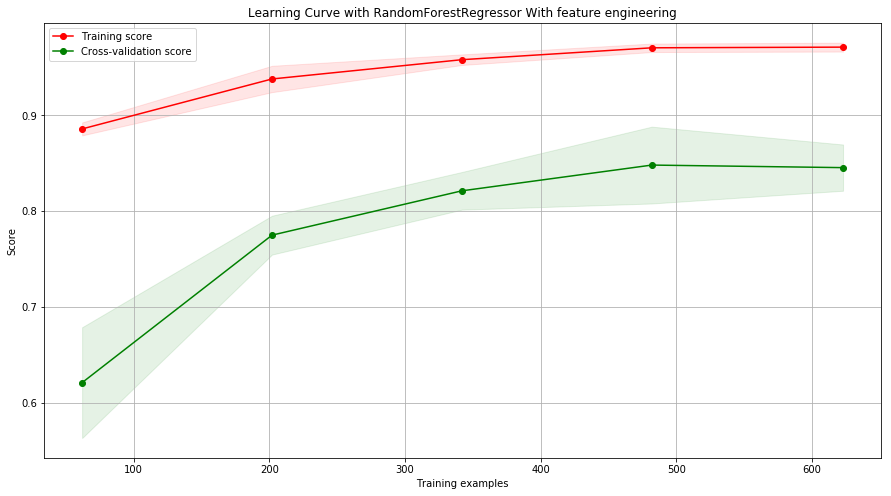

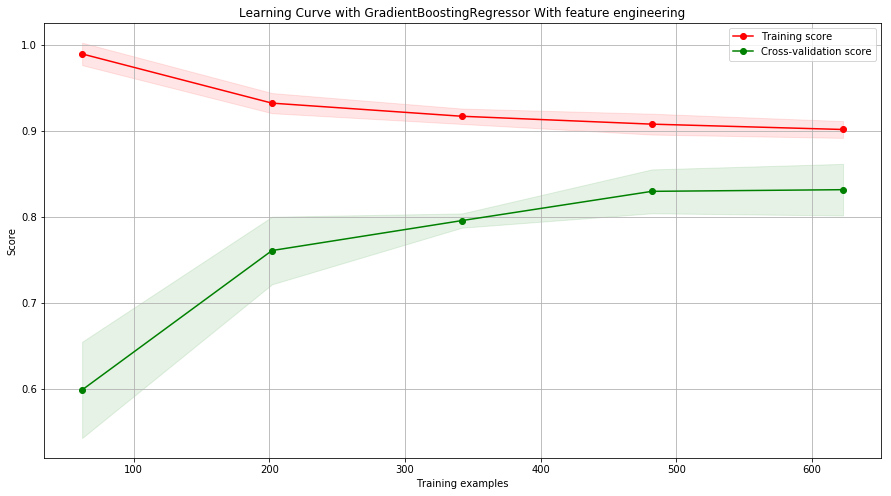

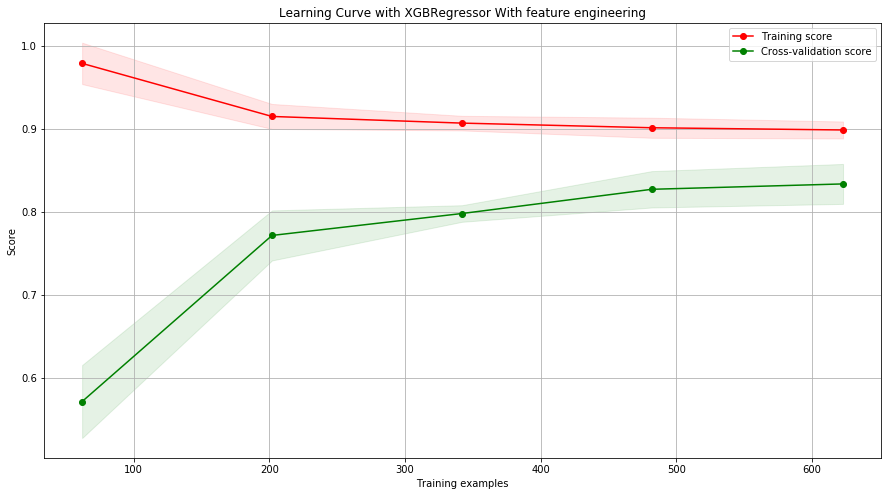

In [101]:
#Plot learning curves for dataset
learning_curve_plot(RandomForestRegressor(),X_1,y,"With feature engineering")
learning_curve_plot(GradientBoostingRegressor(),X_1,y,"With feature engineering")
learning_curve_plot(XGBRegressor(),X_1,y,"With feature engineering")

In [188]:
#Split data into test/train sets
trainX_1, testX_1, trainy_1, testy_1 = train_test_split(X_1, y, test_size=0.75, random_state=42)

In [189]:
#Call regressor functions with a set of data

RFregressor_1_MAE,RF_MAEscores_1 = RFregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_absolute_error")
RFregressor_1_R2,RF_R2scores_1 = RFregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "r2")
RFregressor_1_MSLE,RF_MSLEscores_1 = RFregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_squared_log_error")
print()

GBregressor_1_MAE,GB_MAEscores_1 = GBregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_absolute_error")
GBregressor_1_R2,GB_R2scores_1 = GBregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "r2")
GBregressor_1_MSLE,GB_MSLEscores_1 = GBregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_squared_log_error")
print()

XGBregressor_1_MAE,XGB_MAEscores_1 = XGBregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_absolute_error")
XGBregressor_1_R2,XGB_R2scores_1 = XGBregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "r2")
XGBregressor_1_MSLE,XGB_MSLEscores_1 = XGBregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_squared_log_error")
print()

SVRregressor_1_MAE,SVR_MAEscores_1 = SVRregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_absolute_error")
SVRregressor_1_R2,SVR_R2scores_1 = SVRregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "r2")
SVRregressor_1_MSLE,SVR_MSLEscores_1 = SVRregressorFunct(X_1, y, trainX_1, testX_1, trainy_1, testy_1, "neg_mean_squared_log_error")

The best parameters are {'n_estimators': 382, 'max_features': 6, 'max_depth': 23} with a score of -0.0343
Mean RF neg_mean_absolute_error (train split): -0.0712541387754
Mean RF neg_mean_absolute_error (test split): -0.0351196541794
The best parameters are {'n_estimators': 178, 'max_features': 6, 'max_depth': 15} with a score of 0.8681
Mean RF r2 (train split): 0.669415123138
Mean RF r2 (test split): 0.85949235836
The best parameters are {'n_estimators': 248, 'max_features': 6, 'max_depth': 12} with a score of -0.0028
Mean RF neg_mean_squared_log_error (train split): -0.0079888162226
Mean RF neg_mean_squared_log_error (test split): -0.00273859285229

The best parameters are {'n_estimators': 237, 'max_features': 6, 'max_depth': 8} with a score of -0.0318
Mean GB neg_mean_absolute_error (train split): -0.0721086120355
Mean GB neg_mean_absolute_error (test split): -0.0302437606523
The best parameters are {'n_estimators': 243, 'max_features': 6, 'max_depth': 9} with a score of 0.8556
Mean 

In [190]:
#Comparison with default models (ignore SVR)

RFregressor_def = RandomForestRegressor()
RFregressor_def.fit(trainX_1, trainy_1.values.ravel())
RF_MAEscores_train_def = cross_val_score(RFregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean RF MAE (train split):",np.mean(RF_MAEscores_train_def))
RF_MAEscores_test_def = cross_val_score(RFregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean RF MAE (test split):",np.mean(RF_MAEscores_test_def))

RF_R2scores_train_def = cross_val_score(RFregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="r2")
print("Mean RF R2 (train split):",np.mean(RF_R2scores_train_def))
RF_R2scores_test_def = cross_val_score(RFregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="r2")
print("Mean RF R2 (test split):",np.mean(RF_R2scores_test_def))

RF_MSLEscores_train_def = cross_val_score(RFregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean RF MSLE (train split):",np.mean(RF_MSLEscores_train_def))
RF_MSLEscores_test_def = cross_val_score(RFregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean RF MSLE (test split):",np.mean(RF_MSLEscores_test_def))
print()

GBregressor_def = GradientBoostingRegressor()
GBregressor_def.fit(trainX_1, trainy_1.values.ravel())
GB_MAEscores_train_def = cross_val_score(GBregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean GB MAE (train split):",np.mean(GB_MAEscores_train_def))
GB_MAEscores_test_def = cross_val_score(GBregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean GB MAE (test split):",np.mean(GB_MAEscores_test_def))

GB_R2scores_train_def = cross_val_score(GBregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="r2")
print("Mean GB R2 (train split):",np.mean(GB_R2scores_train_def))
GB_R2scores_test_def = cross_val_score(GBregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="r2")
print("Mean GB R2 (test split):",np.mean(GB_R2scores_test_def))

GB_MSLEscores_train_def = cross_val_score(GBregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean GB MSLE (train split):",np.mean(GB_MSLEscores_train_def))
GB_MSLEscores_test_def = cross_val_score(GBregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean GB MSLE (test split):",np.mean(GB_MSLEscores_test_def))
print()

XGBregressor_def = XGBRegressor()
XGBregressor_def.fit(trainX_1, trainy_1.values.ravel())
XGB_MAEscores_train_def = cross_val_score(XGBregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean XGB MAE (train split):",np.mean(XGB_MAEscores_train_def))
XGB_MAEscores_test_def = cross_val_score(XGBregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="neg_mean_absolute_error")
print("Mean XGB MAE (test split):",np.mean(XGB_MAEscores_test_def))

XGB_R2scores_train_def = cross_val_score(XGBregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="r2")
print("Mean XGB R2 (train split):",np.mean(XGB_R2scores_train_def))
XGB_R2scores_test_def = cross_val_score(XGBregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="r2")
print("Mean XGB R2 (test split):",np.mean(XGB_R2scores_test_def))

XGB_MSLEscores_train_def = cross_val_score(XGBregressor_def, trainX_1, trainy_1.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean XGB MSLE (train split):",np.mean(XGB_MSLEscores_train_def))
XGB_MSLEscores_test_def = cross_val_score(XGBregressor_def, testX_1, testy_1.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
print("Mean XGB MSLE (test split):",np.mean(XGB_MSLEscores_test_def))



Mean RF MAE (train split): -0.0697512532512
Mean RF MAE (test split): -0.037599443904
Mean RF R2 (train split): 0.681183265087
Mean RF R2 (test split): 0.84283549459
Mean RF MSLE (train split): -0.00803346363057
Mean RF MSLE (test split): -0.00312947968324

Mean GB MAE (train split): -0.0771540038283
Mean GB MAE (test split): -0.050670869239
Mean GB R2 (train split): 0.599824893546
Mean GB R2 (test split): 0.810666475288
Mean GB MSLE (train split): -0.00932124581407
Mean GB MSLE (test split): -0.00331321574232

Mean XGB MAE (train split): -0.079139804353
Mean XGB MAE (test split): -0.0502779356848
Mean XGB R2 (train split): 0.594195658777
Mean XGB R2 (test split): 0.816032804768
Mean XGB MSLE (train split): -0.0093421141324
Mean XGB MSLE (test split): -0.00322363760169


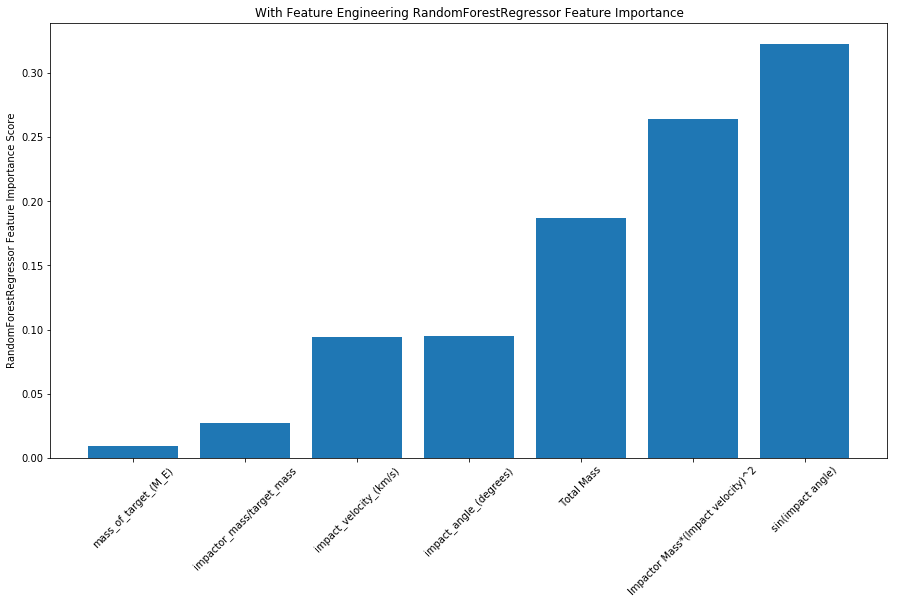

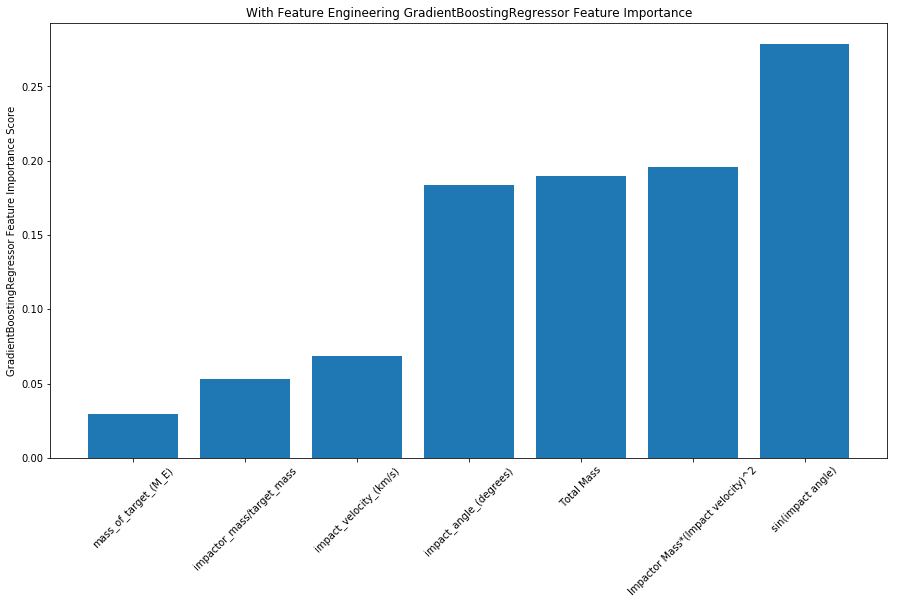

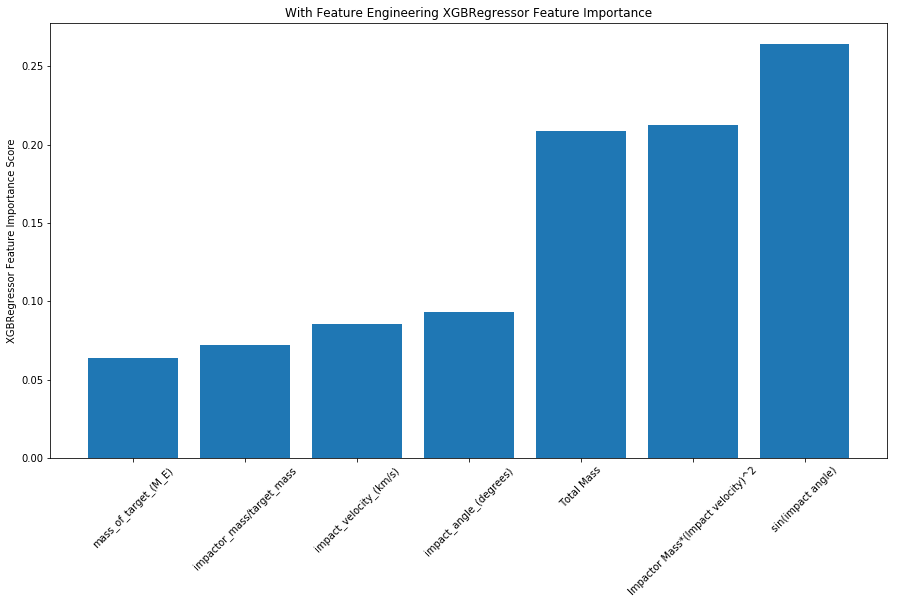

In [191]:
#Plot and compare feature importance between regressors
regressor_list = [RFregressor_1_MSLE,GBregressor_1_MSLE,XGBregressor_1_MSLE]
feature_1 = 'With Feature Engineering'

for regressor in regressor_list:
    feat_imp_plot(regressor,X_1,feature_1)

With Feature Engineering
RandomForestRegressor: 0.99739799397
GradientBoostingRegressor: 0.943739928822
XGBRegressor: 0.953640801836
SVR: 0.958043843831


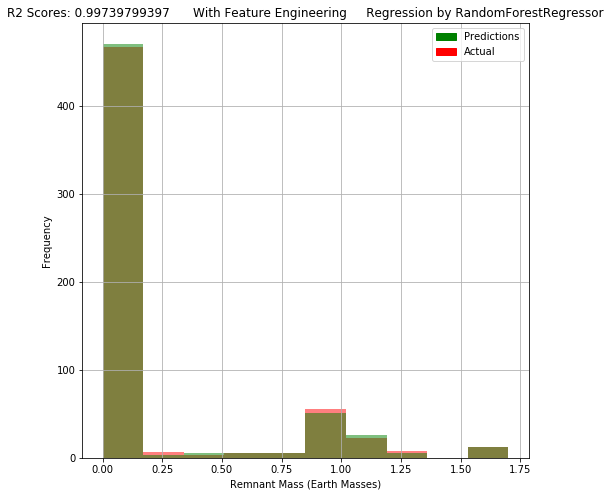

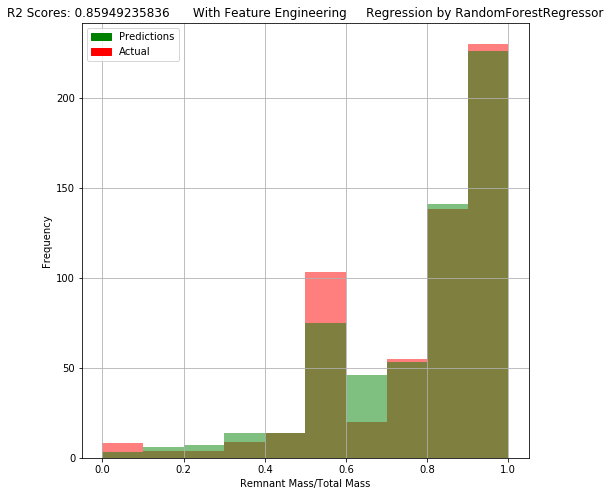

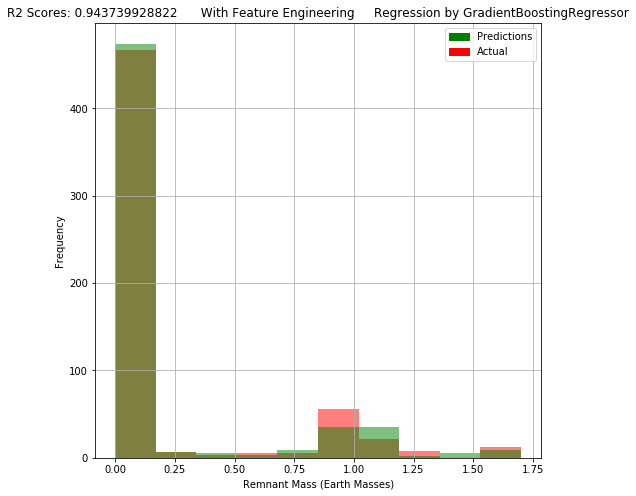

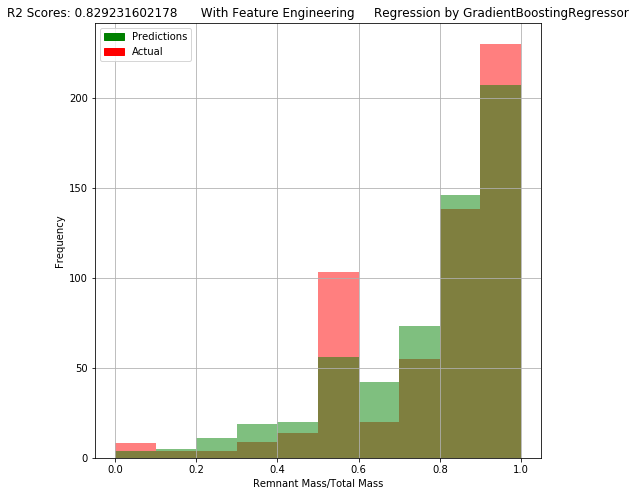

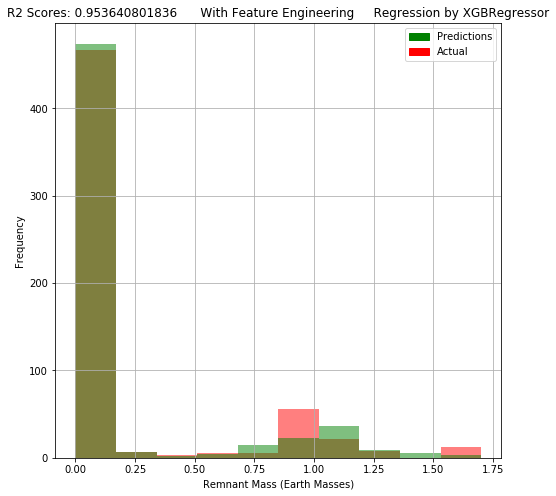

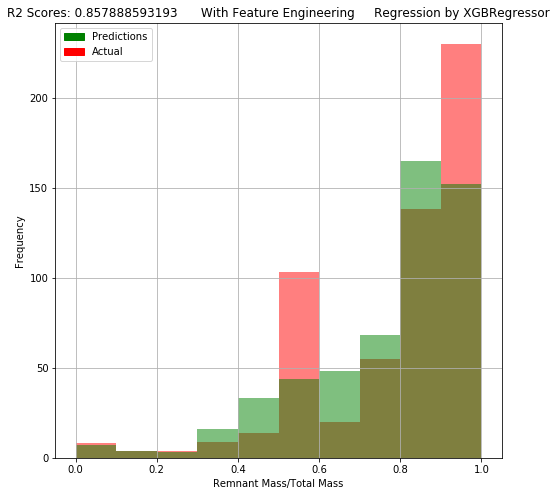

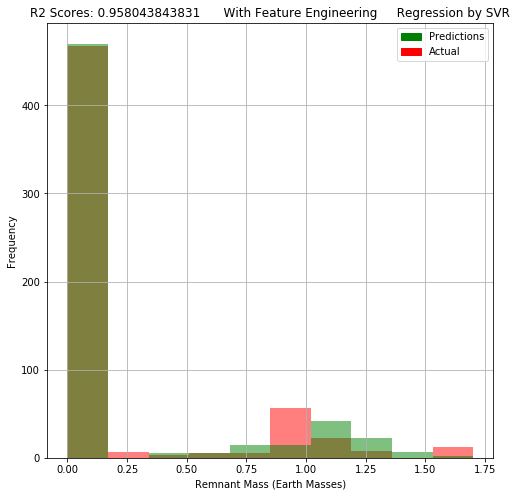

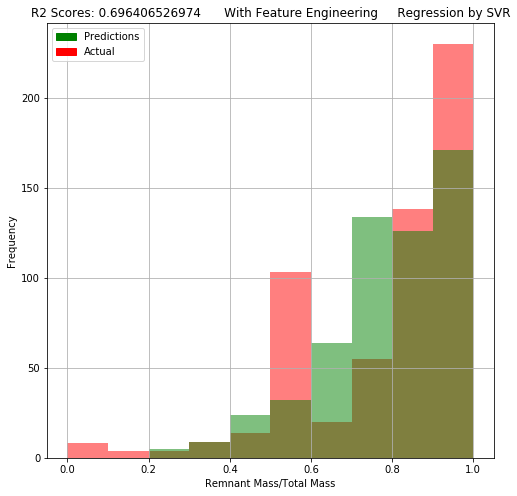

In [285]:
R2regressor_list_1 = [RFregressor_1_R2,GBregressor_1_R2,XGBregressor_1_R2,SVRregressor_1_R2]
R2scores_list_1 = [RF_R2scores_1,GB_R2scores_1,XGB_R2scores_1,SVR_R2scores_1]
R2scores_list_final_1 = []

#Model effectiveness after feature engineering
feature_1 = 'With Feature Engineering'
print(feature_1)
for i in range(len(R2regressor_list_1)):
    R2scores_list_final_1.append(plotfunct(R2regressor_list_1[i],R2scores_list_1[i],feature_1,testX_1,testy_1,"R2",scaler_1))

With Feature Engineering
RandomForestRegressor: 0.025084837694
GradientBoostingRegressor: 0.0260102814335
XGBRegressor: 0.0287192862101
SVR: 0.0363249450644


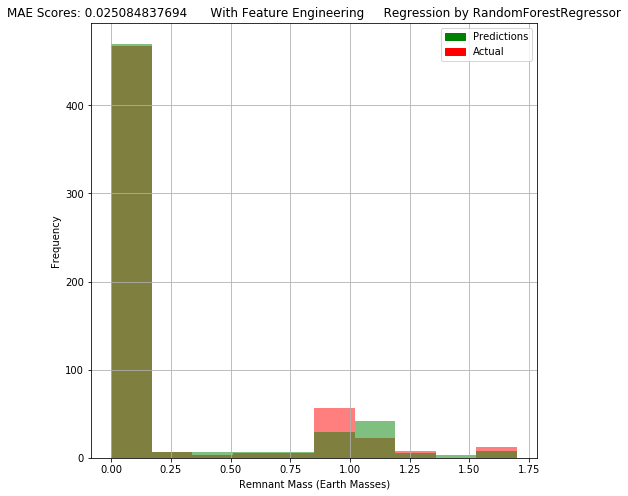

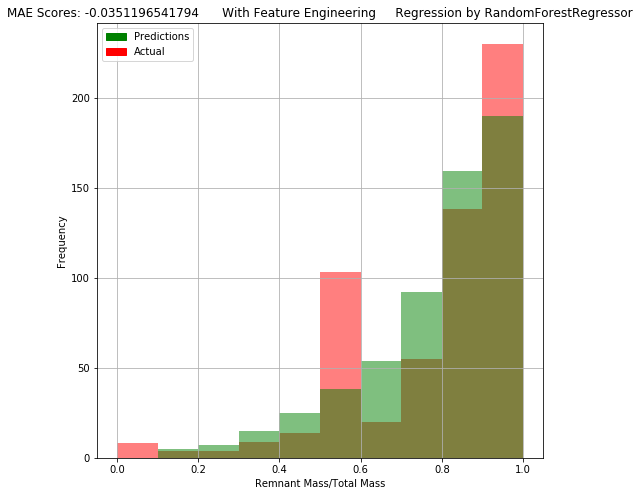

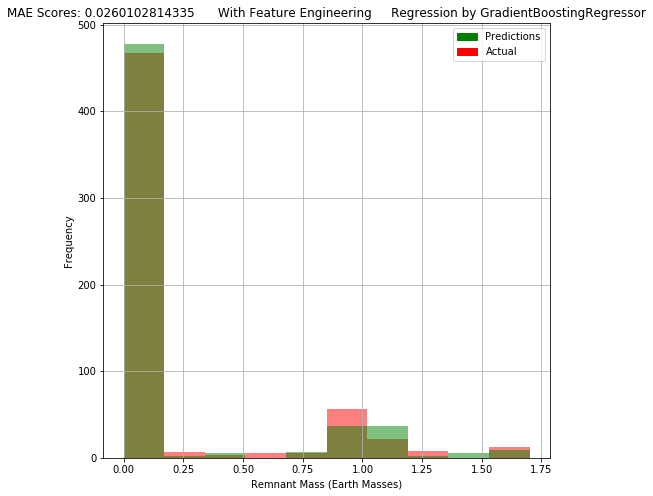

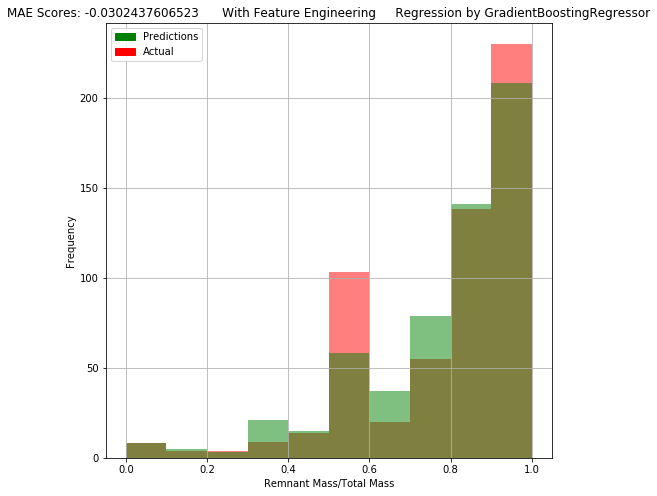

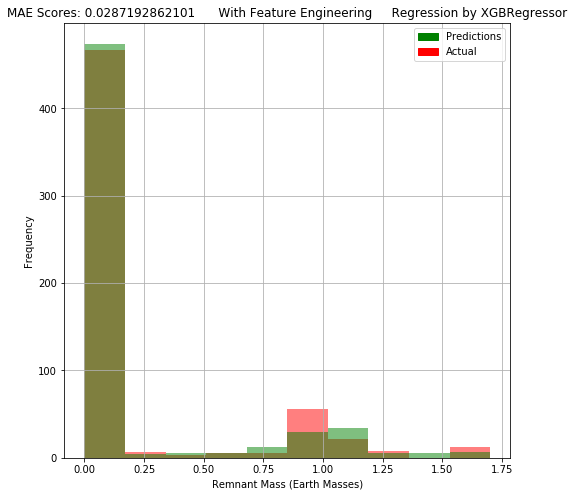

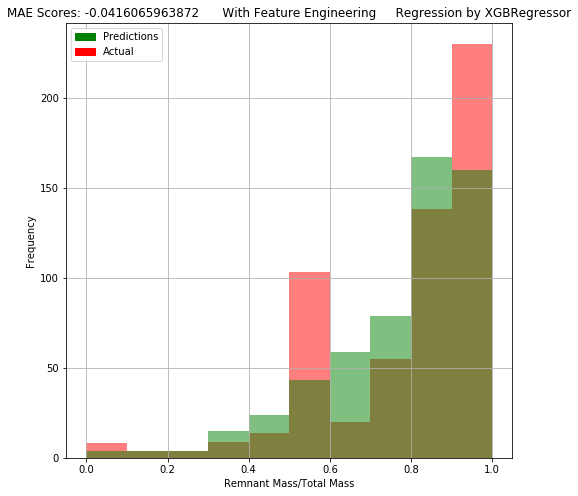

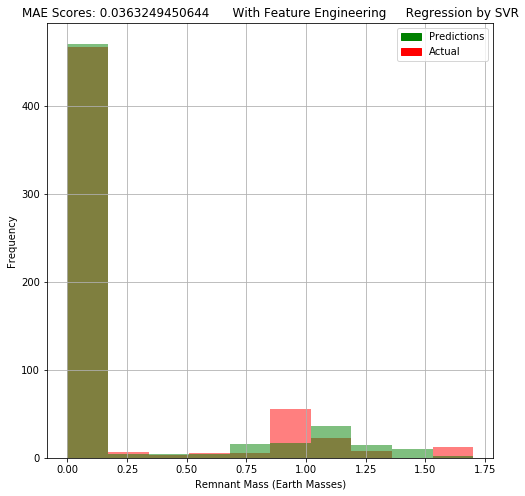

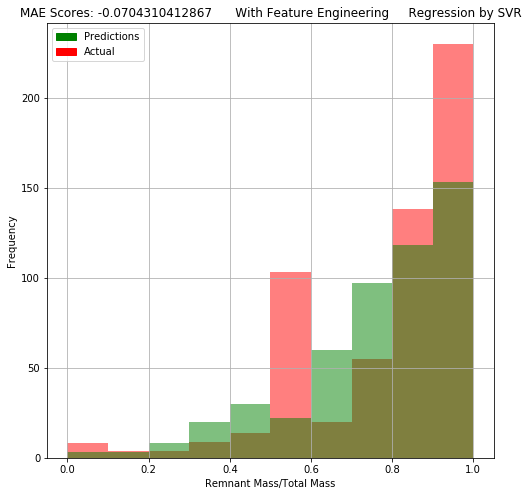

In [286]:
MAEregressor_list_1 = [RFregressor_1_MAE,GBregressor_1_MAE,XGBregressor_1_MAE,SVRregressor_1_MAE]
MAEscores_list_1 = [RF_MAEscores_1,GB_MAEscores_1,XGB_MAEscores_1,SVR_MAEscores_1]
MAEscores_list_final_1 = []

#Model effectiveness after feature engineering
feature_1 = 'With Feature Engineering'
print(feature_1)
for i in range(len(MAEregressor_list_1)):
    MAEscores_list_final_1.append(plotfunct(MAEregressor_list_1[i],MAEscores_list_1[i],feature_1,testX_1,testy_1,"MAE",scaler_1))

With Feature Engineering
RandomForestRegressor: 0.000120420423593
GradientBoostingRegressor: 0.00410104034114
XGBRegressor: 0.0043077748329
SVR: 0.00198539131928


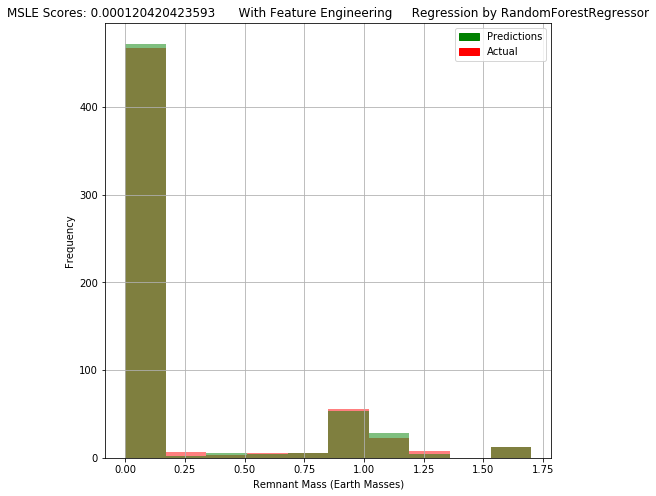

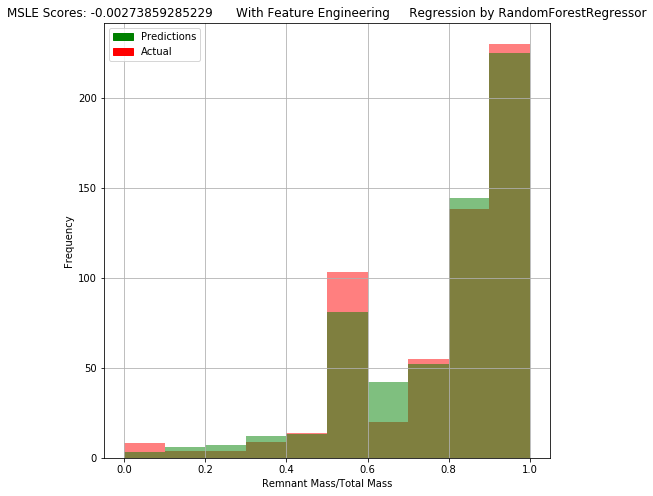

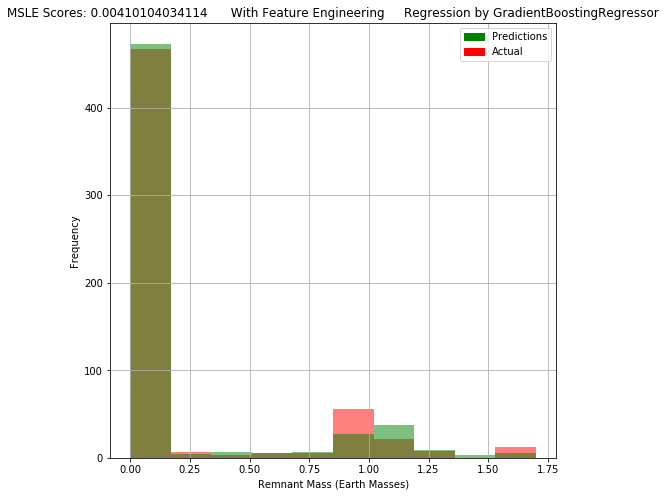

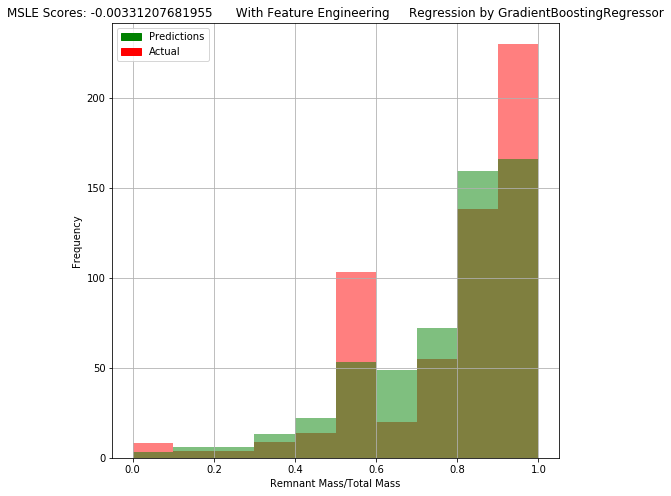

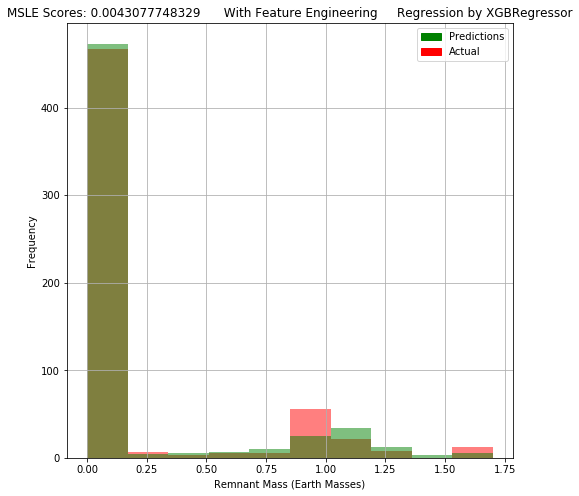

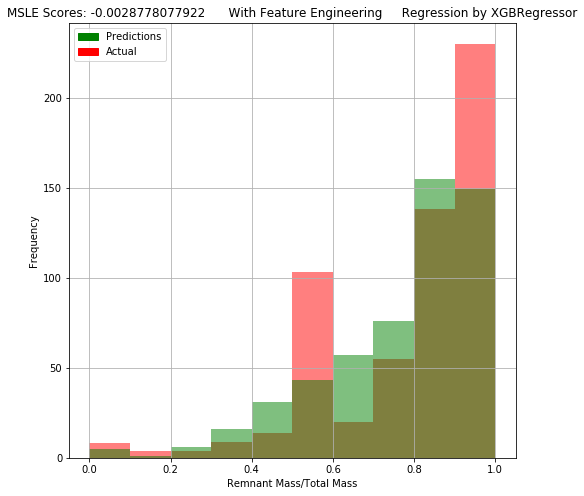

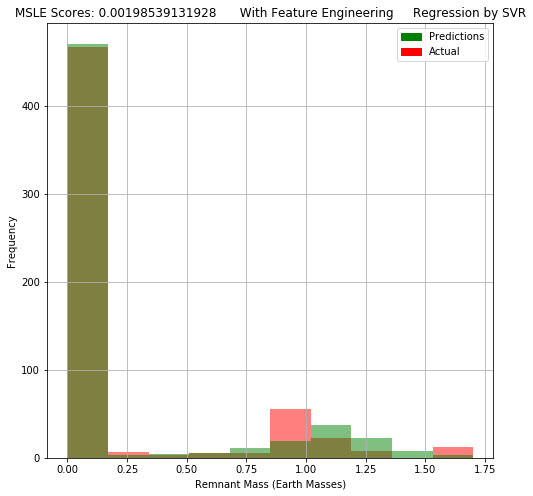

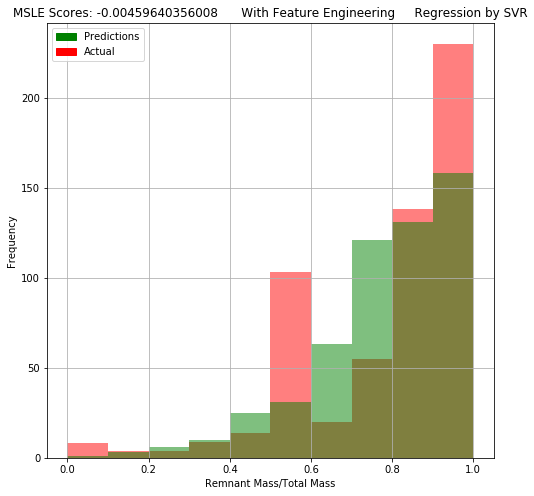

In [287]:
MSLEregressor_list_1 = [RFregressor_1_MSLE,GBregressor_1_MSLE,XGBregressor_1_MSLE,SVRregressor_1_MSLE]
MSLEscores_list_1 = [RF_MSLEscores_1,GB_MSLEscores_1,XGB_MSLEscores_1,SVR_MSLEscores_1]
MSLEscores_list_final_1 = []

#Model effectiveness before feature engineering
feature_1 = 'With Feature Engineering'
print(feature_1)
for i in range(len(MSLEregressor_list_1)):
    MSLEscores_list_final_1.append(plotfunct(MSLEregressor_list_1[i],MSLEscores_list_1[i],feature_1,testX_1,testy_1,"MSLE",scaler_1))

In [253]:
#Print out final comparison scores

print('No Feature Engineering:')  
for score,regressor in zip(R2scores_list_final_0, R2regressor_list_0):
    print("R2 Scores: "+"%.3e" % score+", Regression by "+(str(regressor)).split("(",1)[0])
print()
for score,regressor in zip(MAEscores_list_final_0, MAEregressor_list_0):
    print("MAE Scores: "+"%.3e" % score+", Regression by "+(str(regressor)).split("(",1)[0])
print()
for score,regressor in zip(MSLEscores_list_final_0, MSLEregressor_list_0):
    print("MSLE Scores: "+"%.3e" % score+", Regression by "+(str(regressor)).split("(",1)[0])
    
print()

print('With Feature Engineering:')
for score,regressor in zip(R2scores_list_final_1, R2regressor_list_1):
    print("R2 Scores: "+"%.3e" % score+", Regression by "+(str(regressor)).split("(",1)[0])
print()
for score,regressor in zip(MAEscores_list_final_1, MAEregressor_list_1):
    print("MAE Scores: "+"%.3e" % score+", Regression by "+(str(regressor)).split("(",1)[0])
print()
for score,regressor in zip(MSLEscores_list_final_1, MSLEregressor_list_1):
    print("MSLE Scores: "+"%.3e" % score+", Regression by "+(str(regressor)).split("(",1)[0])

No Feature Engineering:
R2 Scores: 9.687e-01, Regression by RandomForestRegressor
R2 Scores: 9.419e-01, Regression by GradientBoostingRegressor
R2 Scores: 9.488e-01, Regression by XGBRegressor
R2 Scores: 9.591e-01, Regression by SVR

MAE Scores: 2.565e-02, Regression by RandomForestRegressor
MAE Scores: 2.688e-02, Regression by GradientBoostingRegressor
MAE Scores: 2.887e-02, Regression by XGBRegressor
MAE Scores: 3.242e-02, Regression by SVR

MSLE Scores: 2.071e-03, Regression by RandomForestRegressor
MSLE Scores: 4.721e-03, Regression by GradientBoostingRegressor
MSLE Scores: 2.047e-03, Regression by XGBRegressor
MSLE Scores: 1.944e-03, Regression by SVR

With Feature Engineering:
R2 Scores: 9.700e-01, Regression by RandomForestRegressor
R2 Scores: 9.437e-01, Regression by GradientBoostingRegressor
R2 Scores: 9.536e-01, Regression by XGBRegressor
R2 Scores: 9.580e-01, Regression by SVR

MAE Scores: 2.508e-02, Regression by RandomForestRegressor
MAE Scores: 2.601e-02, Regression by Gr

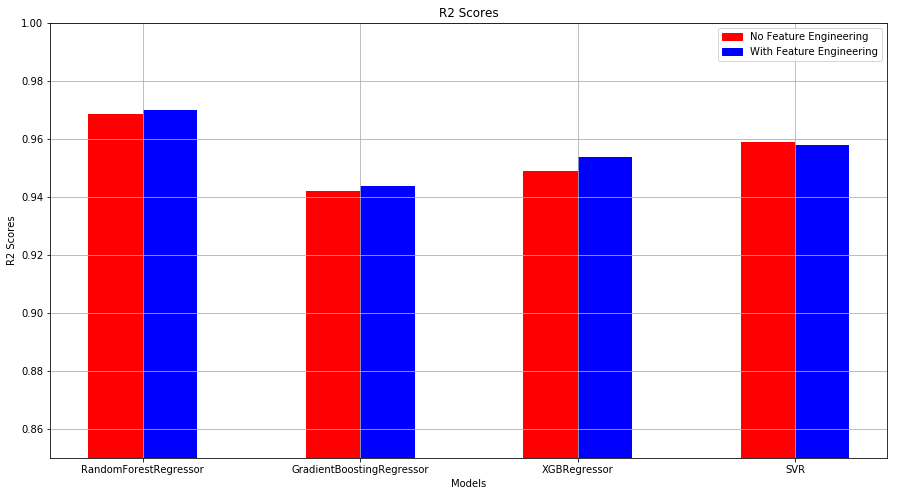

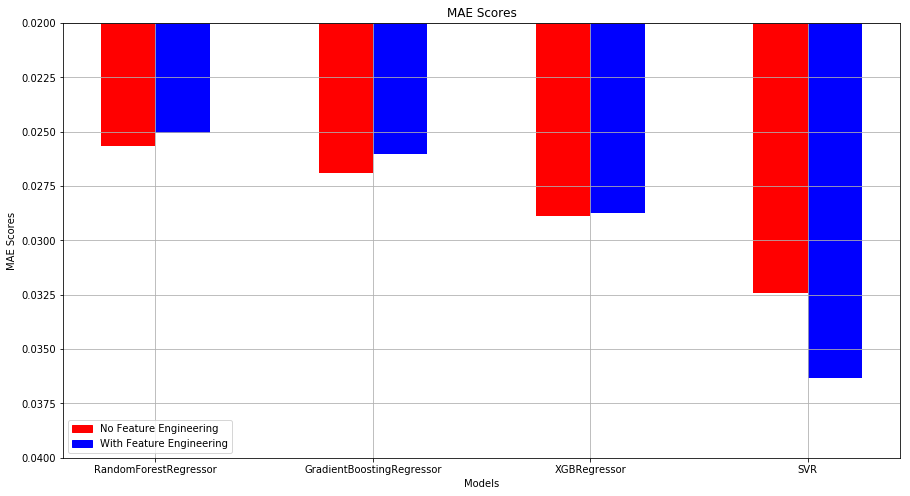

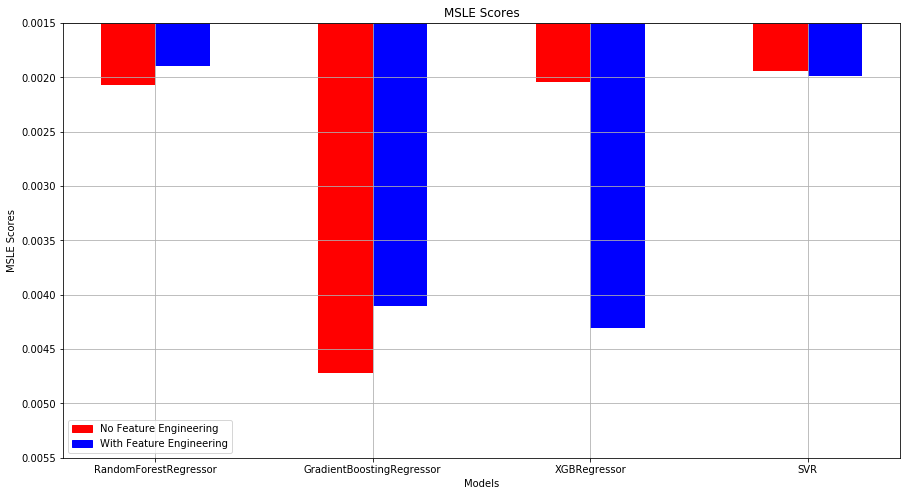

In [254]:
#Plot final scores
regressor_list_plot = []
for regressor in R2regressor_list_0:
    regressor = (str(regressor)).split("(",1)[0]
    regressor_list_plot.append(regressor)
    
ind = np.arange(4)
width = 0.25        
red_patch, blue_patch = mpatches.Patch(color="red", label="No Feature Engineering"),mpatches.Patch(color="blue", label="With Feature Engineering")

fig, ax = plt.subplots(figsize=(15,8))
plt.bar(ind,R2scores_list_final_0,width,color="red")
plt.bar(ind+width,R2scores_list_final_1,width,color="blue")
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(regressor_list_plot)
plt.ylim([0.85, 1.])
plt.legend(handles=[red_patch,blue_patch], loc="best")
plt.title("R2 Scores")
plt.xlabel("Models")
plt.ylabel("R2 Scores")
plt.grid()
plt.savefig("R2 Score Model Comparison (New).png", bbox_inches='tight', format='png')

fig, ax = plt.subplots(figsize=(15,8))
plt.bar(ind,MAEscores_list_final_0,width,color="red")
plt.bar(ind+width,MAEscores_list_final_1,width,color="blue")
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(regressor_list_plot)
plt.ylim([0.040, 0.020])
plt.legend(handles=[red_patch,blue_patch], loc="best")
plt.title("MAE Scores")
plt.xlabel("Models")
plt.ylabel("MAE Scores")
plt.grid()
plt.savefig("MAE Score Model Comparison (New).png", bbox_inches='tight', format='png')

fig, ax = plt.subplots(figsize=(15,8))
plt.bar(ind,MSLEscores_list_final_0,width,color="red")
plt.bar(ind+width,MSLEscores_list_final_1,width,color="blue")
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(regressor_list_plot)
plt.ylim([0.0055, 0.0015])
plt.legend(handles=[red_patch,blue_patch], loc="best")
plt.title("MSLE Scores")
plt.xlabel("Models")
plt.ylabel("MSLE Scores")
plt.grid()
plt.savefig("MSLE Score Model Comparison (New).png", bbox_inches='tight', format='png')

# Final Prediction

In [268]:
#Predictions of best model

#Use entire dataset for final model
RFregressor_1_MSLE.fit(X_1,y.values.ravel())

#Read-in test data
ImpCol = pd.read_csv("data/Impacts_test_set_features.csv")
ImpCol_X = ImpCol.drop(['Unnamed: 0'], axis=1)
print(ImpCol_X.describe())

       mass_of_target_(M_E)  impactor_mass/target_mass  \
count            260.000000                 260.000000   
mean               0.210821                   0.356731   
std                0.354617                   0.234568   
min                0.000100                   0.100000   
25%                0.010000                   0.200000   
50%                0.100000                   0.200000   
75%                0.100000                   0.700000   
max                1.000000                   0.700000   

       impact_velocity_(km/s)  impact_angle_(degrees)  
count              260.000000              260.000000  
mean                 1.949808               43.571538  
std                  0.986242               26.366897  
min                  1.000000                0.100000  
25%                  1.150000               22.500000  
50%                  1.500000               45.000000  
75%                  2.625000               60.000000  
max                  4.000000

In [269]:
#Modify and Scale
ImpCol_testX = ImpCol_X.loc[:,'mass_of_target_(M_E)':'impact_angle_(degrees)']
ImpCol_testX['Total Mass'] = ImpCol_testX['mass_of_target_(M_E)']+(ImpCol_testX['impactor_mass/target_mass']*ImpCol_testX['mass_of_target_(M_E)'])
ImpCol_testX['Impactor Mass*(Impact velocity)^2'] = (ImpCol_testX['mass_of_target_(M_E)']*ImpCol_testX['impactor_mass/target_mass'])*(ImpCol_testX['impact_velocity_(km/s)'])**2
ImpCol_testX['sin(impact angle)'] = np.sin(np.deg2rad(ImpCol_testX['impact_angle_(degrees)']))

#ImpCol_testX['Adjusted Target Mass'] = ImpCol_testX['mass_of_target_(M_E)']/ImpCol_testX['Total Mass']
#ImpCol_testX = ImpCol_testX.drop(ImpCol_testX.columns[0],axis=1)
print(ImpCol_testX.tail())

ImpCol_testX, scaler = datascale(ImpCol_testX)

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

     mass_of_target_(M_E)  impactor_mass/target_mass  impact_velocity_(km/s)  \
255                1.0000                       0.70                     1.8   
256                0.1000                       0.20                     1.3   
257                0.0001                       0.20                     1.7   
258                0.1000                       0.35                     3.5   
259                1.0000                       0.70                     2.5   

     impact_angle_(degrees)  Total Mass  Impactor Mass*(Impact velocity)^2  \
255                    22.5     1.70000                           2.268000   
256                    60.0     0.12000                           0.033800   
257                    22.5     0.00012                           0.000058   
258                    37.5     0.13500                           0.428750   
259                    37.5     1.70000                           4.375000   

     sin(impact angle)  
255           0.382683  


C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [270]:
ImpCol_y_pred = RFregressor_1_MSLE.predict(ImpCol_testX)*(scaler.inverse_transform(ImpCol_testX)[:,4])
#print(ImpCol_y_pred_1.shape)
#print(ImpCol_y_pred)

#Apply inverse transform of standard scaler
print("RF Remnant Mass predictions:",ImpCol_y_pred)

RF Remnant Mass predictions: [  3.97258065e-03   1.00789346e-02   9.67298817e-04   8.42580115e-05
   9.92856571e-02   1.13258390e-02   9.49810936e-04   8.91853437e-02
   1.00794616e-01   1.03169893e-01   1.05210534e-04   1.19157006e-04
   1.67553951e-02   9.72397340e-02   1.04031027e-04   9.61221565e-02
   9.73209375e-01   1.15382125e-01   9.46462054e-04   9.91048602e-03
   8.24598204e-01   1.00387427e-02   1.00155899e+00   1.09856469e-01
   1.14312698e-03   1.09382580e-01   9.40350084e-03   1.13144061e-01
   1.15161962e-03   1.07682461e-02   9.99531250e-05   9.70823487e-01
   1.31930219e-01   1.00271420e-02   9.99967902e-02   1.16101958e+00
   1.12074384e-03   1.05493978e-02   8.51533864e-03   1.52326110e-01
   8.59996962e-04   1.19598731e-01   1.17090329e-02   9.97644086e-01
   9.97423739e-05   1.03673043e-01   1.17379108e-02   1.12695767e+00
   9.97891204e-01   9.05200030e-01   1.06758830e+00   1.03001955e-01
   1.01794652e+00   1.21328172e-01   1.00860163e-02   7.15883337e-02
   1.

In [271]:
ImpCol_submit = ImpCol.copy()
ImpCol_submit.drop(ImpCol_submit.columns[1:], axis=1, inplace=True)
ImpCol_submit['mass_of_the_largest_remnant_(M_E)'] = ImpCol_y_pred

print(ImpCol_submit.describe())

        Unnamed: 0  mass_of_the_largest_remnant_(M_E)
count   260.000000                         260.000000
mean    501.526923                           0.212311
std     316.158902                           0.375389
min       6.000000                           0.000073
25%     202.000000                           0.009926
50%     492.500000                           0.095122
75%     768.750000                           0.120237
max    1037.000000                           1.688216


In [272]:
ImpCol_submit.to_csv("data/EESC24 - Impact Collisions (Newer) Submission (Michael Wong).csv",index=False)